# Part A: DCGAN

## What is a DCGAN?

A **Deep Convolutional Generative Adversarial Network (DCGAN)** is a type of Generative Adversarial Network (GAN) that uses deep convolutional layers in both its Generator and Discriminator architectures. It is especially well-suited for image generation tasks.

### Key Components:
- **Generator**: Learns to produce realistic-looking images from random noise (latent vectors). It uses transpose convolutional layers (`Conv2DTranspose`) to upsample low-dimensional noise into a full-sized image.
  
- **Discriminator**: Acts as a binary classifier that distinguishes between real images (from the dataset) and fake images (from the generator). It uses convolutional layers to extract features and make a real/fake prediction.

- **Adversarial Training**: 
  - The generator tries to fool the discriminator by generating more realistic images.
  - The discriminator tries to get better at identifying fakes.
  - Over time, both networks improve through this adversarial process, resulting in high-quality generated images.

### Our Implementation

In our case, we use **one unconditional DCGAN model** trained on all 16 classes of the dataset.

- **Unconditional** means that the generator does not take class labels as input, it only uses random noise to create images.  
- As a result, the generated samples are random images from across all classes, without control over which class is produced.


## Table of Contents
1. <a href="#imports">Imports</a>  
2. <a href="#control-gpu-memory-usage">Control GPU Memory Usage</a>  
3. <a href="#background-research-and-data-exploration">Background Research and Data Exploration</a>  
4. <a href="#data-exploration">Data Exploration</a>  
5. <a href="#feature-engineering">Feature Engineering</a>  
6. <a href="#application-of-dcgan">Application of DCGAN</a>  
7. <a href="#baseline-dcgan-model">Baseline DCGAN Model</a>  
8. <a href="#dcgan-model-improvement-4-500-epochs">DCGAN Model Improvement - 500 epochs</a>  


<a id="imports"></a>
# Imports

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Reshape, Conv2DTranspose, BatchNormalization,
                                     Activation, Conv2D, LeakyReLU, Dropout, Flatten)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


<a id="control-gpu-memory-usage"></a>
# Control GPU Memory Usage

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id="background-research-and-data-exploration"></a>
# Background Research and Data Explorationn

### Load Dataset

In [4]:
df = pd.read_csv('emnist-letters-train.csv')

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
labels = df.iloc[:, 0]
images = df.iloc[:, 1:].values

<a id="data-exploration"></a>
# Data Exploration

In [7]:
df.head()

24    0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.552  0.553  0.554  \
0  -2  142  142  142  142  142  142  142  142  142  ...    142    142    142   
1  15    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  14    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  -2  120  120  120  120  120  120  120  120  120  ...    120    120    120   
4  -1  131  131  131  131  131  131  131  131  200  ...    131    131    131   

   0.555  0.556  0.557  0.558  0.559  0.560  0.561  
0    142    142    142    142    142    142    142  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3    120    120    120    120    120    120    120  
4    131    131    131    131    131    131    131  

[5 rows x 785 columns]

In [8]:
df.shape

(55363, 785)

In [9]:
df.describe()

24             0           0.1           0.2           0.3  \
count  55363.000000  55363.000000  55363.000000  55363.000000  55363.000000   
mean      11.589003      1.787602      1.787602      1.787602      1.787710   
std        7.467979     17.352303     17.352303     17.352303     17.368913   
min       -2.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.000000      0.000000      0.000000      0.000000      0.000000   
50%       10.000000      0.000000      0.000000      0.000000      0.000000   
75%       16.000000      0.000000      0.000000      0.000000      0.000000   
max       26.000000    255.000000    255.000000    255.000000    255.000000   

                0.4           0.5           0.6          0.7           0.8  \
count  55363.000000  55363.000000  55363.000000  55363.00000  55363.000000   
mean       1.791991      1.810921      1.819807      1.81009      2.259542   
std       17.359561     17.449014     17.500948     17.45474     19.855490   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        0.000000      0.000000      0.000000      0.00000      0.000000   
50%        0.000000      0.000000      0.000000      0.00000      0.000000   
75%        0.000000      0.000000      0.000000      0.00000      0.000000   
max      255.000000    255.000000    255.000000    255.00000    255.000000   

       ...         0.552         0.553         0.554         0.555  \
count  ...  55363.000000  55363.000000  55363.000000  55363.000000   
mean   ...      1.787602      1.787602      1.787602      1.792479   
std    ...     17.352303     17.352303     17.352303     17.383111   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...    255.000000    255.000000    255.000000    255.000000   

              0.556         0.557         0.558         0.559         0.560  \
count  55363.000000  55363.000000  55363.000000  55363.000000  55363.000000   
mean       1.788180      1.787602      1.787602      1.787602      1.787602   
std       17.352776     17.352303     17.352303     17.352303     17.352303   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

              0.561  
count  55363.000000  
mean       1.787602  
std       17.352303  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      255.000000  

[8 rows x 785 columns]

In [10]:
print("Unique labels:", sorted(labels.unique()))

Unique labels: [-2, -1, 1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]


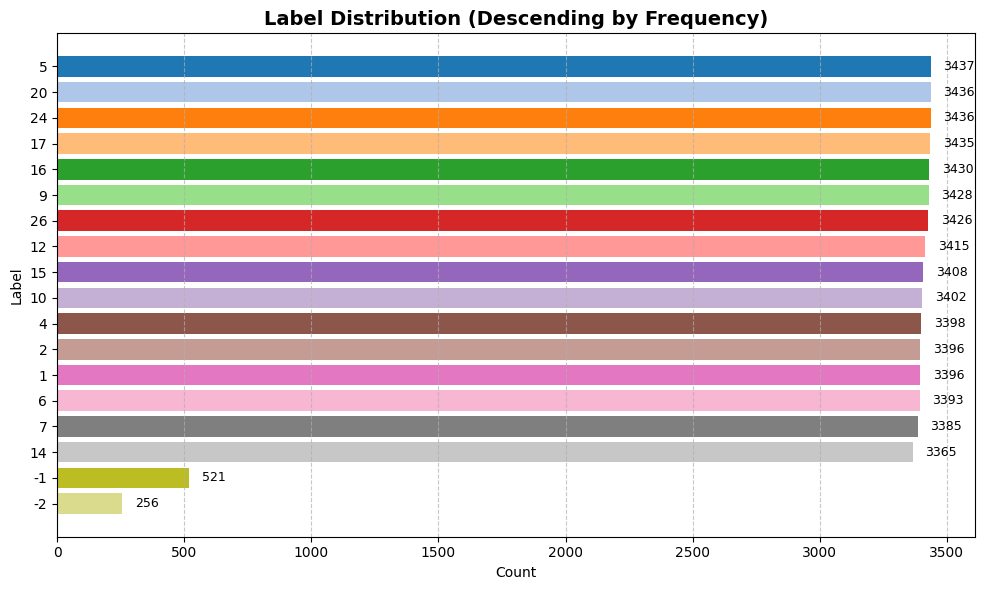

In [11]:
import matplotlib.pyplot as plt

# Count occurrences and sort by frequency (descending)
label_counts = labels.value_counts().sort_values(ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(label_counts.index.astype(str), label_counts.values, color=plt.cm.tab20.colors)

# Add count values next to bars
for bar, value in zip(bars, label_counts.values):
    plt.text(value + 50, bar.get_y() + bar.get_height()/2,
             str(value), va='center', fontsize=9)

plt.title("Label Distribution (Descending by Frequency)", fontsize=14, fontweight='bold')
plt.xlabel("Count")
plt.ylabel("Label")
plt.gca().invert_yaxis()  # Highest count at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
label_counts = labels.value_counts().sort_index()
print(label_counts)

24
-2      256
-1      521
 1     3396
 2     3396
 4     3398
 5     3437
 6     3393
 7     3385
 9     3428
 10    3402
 12    3415
 14    3365
 15    3408
 16    3430
 17    3435
 20    3436
 24    3436
 26    3426
Name: count, dtype: int64


Two significantly underrepresented labels –
- Label -1: 521 samples
- Label -2: 256 samples

Before we drop them, let us explore what they are first.


-----

## Plot sample images by class

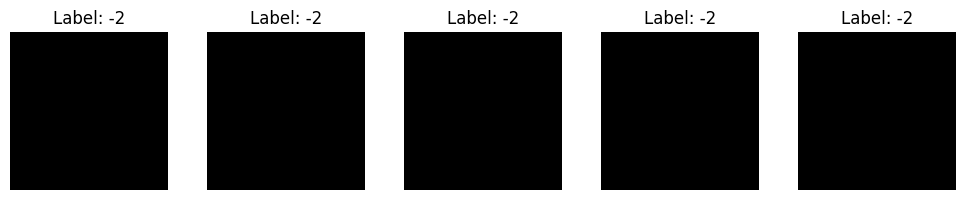

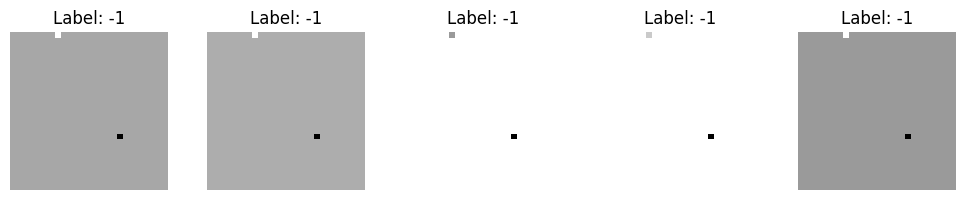

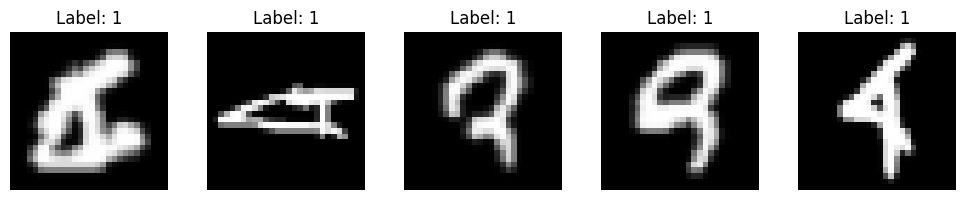

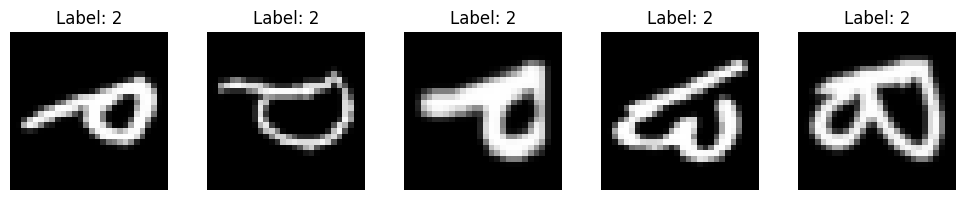

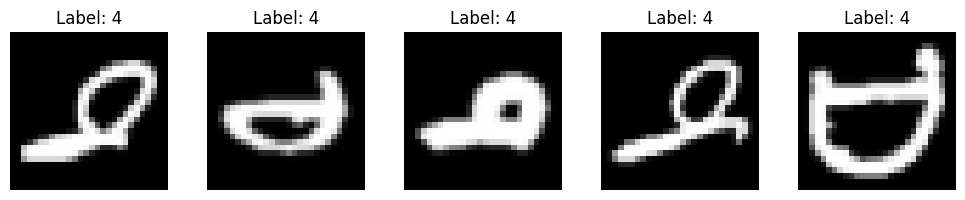

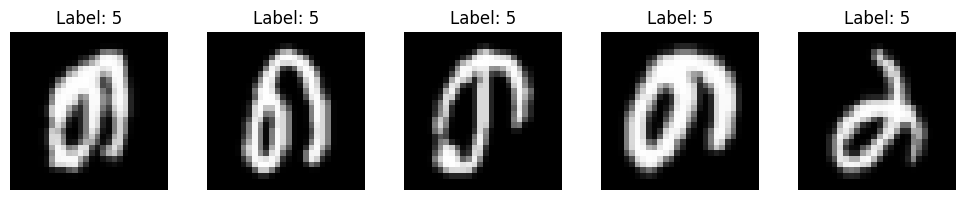

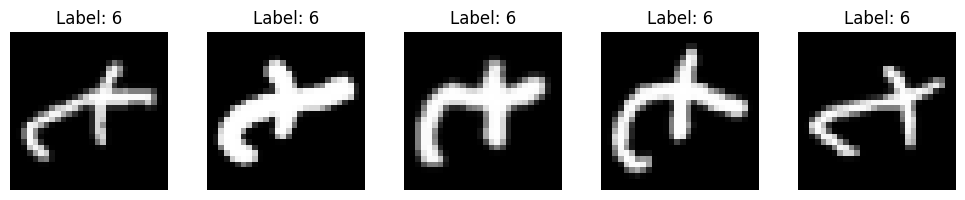

In [13]:
# Helper function to plot images by class
def plot_class_images(class_label, n=5):
    indices = df[df.iloc[:, 0] == class_label].index[:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        img = images[idx].reshape(28, 28)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {class_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_images(-2)
plot_class_images(-1)
plot_class_images(1)
plot_class_images(2)
plot_class_images(4)
plot_class_images(5)
plot_class_images(6)

- Each label corresponds to a letter in the EMNIST dataset
- Labels -2 and -1 appear to be mostly blank or minimal marks
- Other labels (e.g., 1, 2, 4, 5, 6) show handwritten letter variations.
- Variation in handwriting style and stroke thickness may affect GAN training quality.


<a id="filter-reset"></a>
# Filter Out Unwanted Labels 


In [14]:
df = df[~labels.isin([-1, -2])].copy()
df.reset_index(drop=True, inplace=True)

In [15]:
labels = df.iloc[:, 0]
images = df.iloc[:, 1:].values

In [16]:
print("Unique labels after cleaning:", sorted(labels.unique()))

Unique labels after cleaning: [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]


-------------

## Image Average

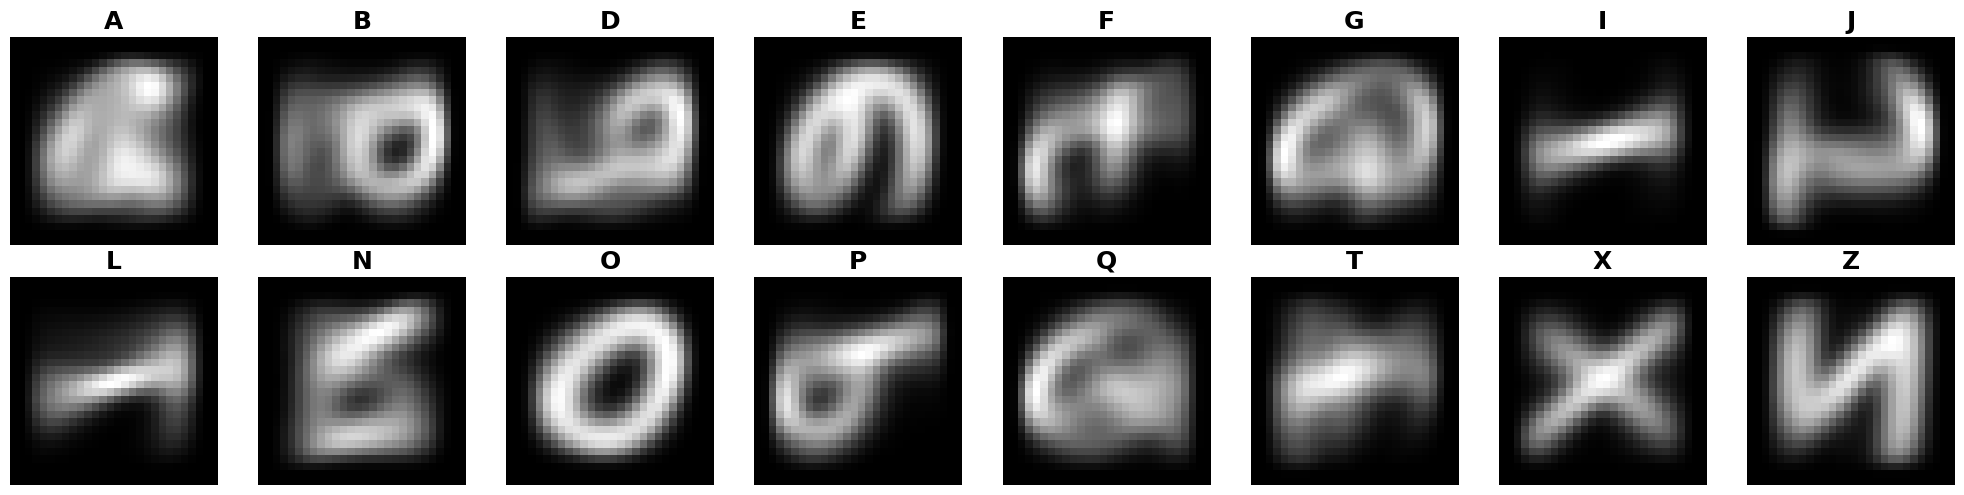

In [13]:
import numpy as np
import matplotlib.pyplot as plt


images = images.reshape(-1, 28, 28)
labels = np.asarray(labels).astype(int)

chosen = list("ABDEFGIJLNOPQTXZ")   # 16 letters
rows, cols = 2, 8
fig, ax = plt.subplots(rows, cols, figsize=(20, 5))
ax = ax.ravel()

for i, ch in enumerate(chosen):
    lab = ord(ch.lower()) - 96       # 'a'->1, ..., 'z'->26
    class_imgs = images[labels == lab]

    avg_img = np.mean(class_imgs, axis=0) if len(class_imgs) else np.zeros((28, 28))
    ax[i].imshow(avg_img, cmap='gray')
    ax[i].set_title(ch, fontsize=18, fontweight='bold')
    ax[i].axis('off')

# hide any leftover axes (shouldn't be any, but just in case)
for j in range(len(chosen), rows*cols):
    ax[j].axis('off')

plt.tight_layout()
plt.show()


- These are the per-letter average images for the 16 target classes, and they appear blurry due to variations in handwriting styles across samples.
- Hard to distinguish the features
----

<a id="feature-engineering"></a>
# Feature Engineering

### Image Preprocessing Summary

To prepare the EMNIST images for Conditional GAN training, the following preprocessing steps were applied:

1. **Reshape**  
   The flat image arrays were reshaped into 28×28 pixel format to match the original image dimensions.

2. **Rotate and Flip**  
   The EMNIST dataset stores images in a transposed and inverted format. We corrected this by rotating each image 90 degrees counter-clockwise and flipping it horizontally to restore proper orientation.

3. **Expand Dimensions**  
   A channel dimension was added to represent grayscale format, resulting in image shapes of (28, 28, 1) — required for convolutional neural networks.

4. **Normalize**  
   Pixel values were scaled from the original [0, 255] range to [-1, 1], which is important for stabilizing GAN training and matching the output activation (`tanh`) of the generator.


In [17]:
# Normalize pixel values to [-1, 1]
images = (images - 127.5) / 127.5

# Reshape and fix orientation: rotate 90° clockwise then flip horizontally
images = images.reshape(-1, 28, 28)
images = np.array([np.fliplr(np.rot90(img, k=-1)) for img in images])  # Changed k=1 to k=-1:  rotate 90° clockwise once.

# Reshape back to (N, 28, 28, 1) 
images = images.reshape(-1, 28, 28, 1)

# Confirm shape
print("Final image shape:", images.shape)

Final image shape: (54586, 28, 28, 1)


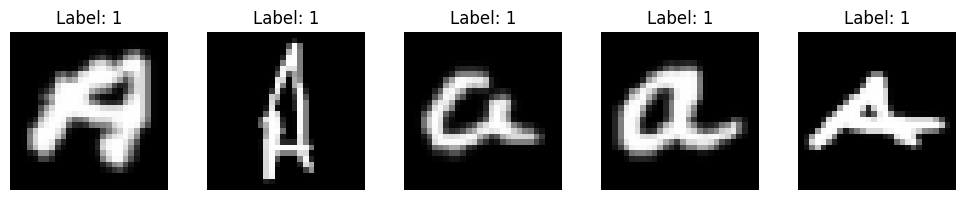

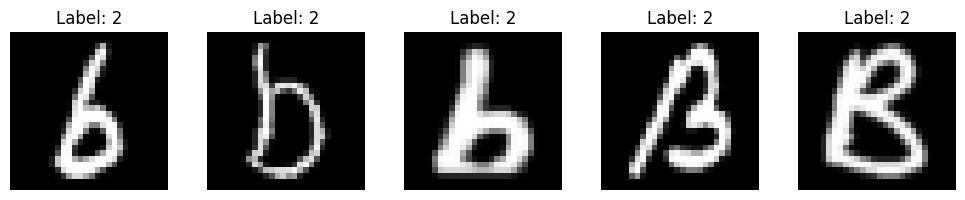

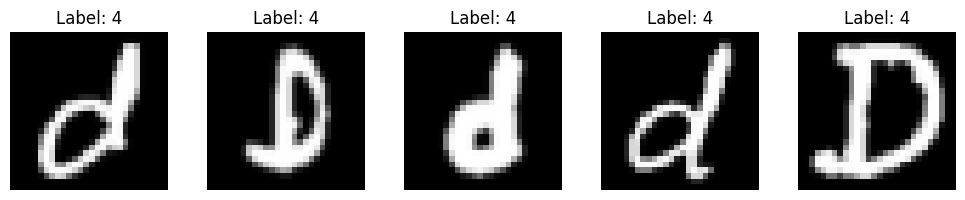

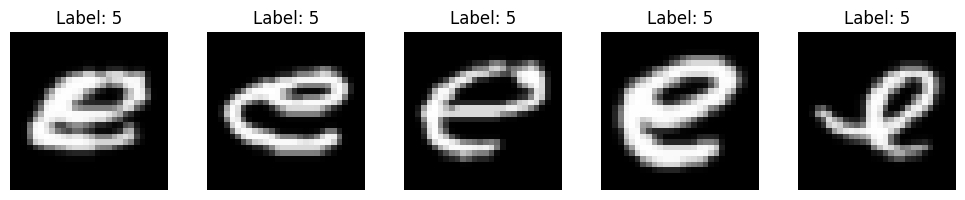

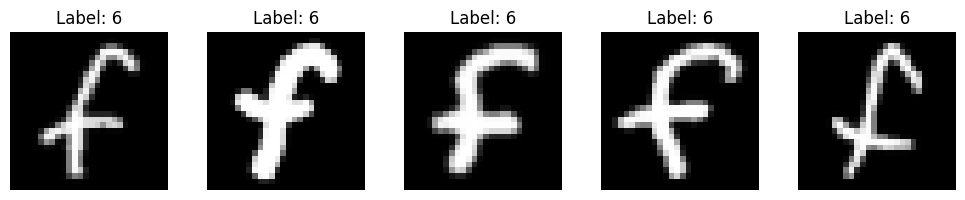

In [18]:
# Helper function to plot images by class
def plot_class_images(class_label, n=5):
    indices = df[df.iloc[:, 0] == class_label].index[:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        img = images[idx].reshape(28, 28)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {class_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_images(1)
plot_class_images(2)
plot_class_images(4)
plot_class_images(5)
plot_class_images(6)

<a id="application-of-dcgan"></a>
# Application of DCGAN

In [19]:
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D


<a id="baseline-dcgan-model"></a>
# Baseline DCGAN Model


**Unconditional DCGAN Architecture — Design Choices**

| Model            | Layer / Operation | Output Shape      | Why This Choice |
|------------------|-------------------|-------------------|-----------------|
| **Generator**    | Input             | (latent_dim,)     | Random noise vector to allow diverse image generation. |
|                  | Dense             | (7×7×128)         | Large feature map for more detail capture at start. |
|                  | Reshape           | (7, 7, 128)       | Convert dense output into spatial feature maps. |
|                  | UpSampling2D      | (14, 14, 128)     | Doubles resolution while preserving learned features. |
|                  | Conv2D (128)      | (14, 14, 128)     | Adds spatial detail after upsampling. |
|                  | BatchNormalization| (14, 14, 128)     | Stabilizes activations and improves training convergence. |
|                  | ReLU               | (14, 14, 128)     | Encourages positive activations for better feature growth. |
|                  | UpSampling2D      | (28, 28, 128)     | Final resolution upsampling to target image size. |
|                  | Conv2D (64)       | (28, 28, 64)      | Adds finer detail features. |
|                  | BatchNormalization| (28, 28, 64)      | Keeps generator training stable. |
|                  | ReLU               | (28, 28, 64)      | Activation to enhance feature learning. |
|                  | Conv2D (Output)   | (28, 28, channels)| Outputs grayscale image, `tanh` for range [-1, 1] matching preprocessing. |




| Model            | Layer / Operation | Output Shape      | Why This Choice |
|------------------|-------------------|-------------------|-----------------|
| **Discriminator**| Input             | (28, 28, channels)| Takes real or generated images for classification. |
|                  | Conv2D (64)       | (14, 14, 64)      | Extracts low-level patterns while reducing resolution. |
|                  | LeakyReLU(0.2)    | (14, 14, 64)      | Avoids dead neurons, keeps gradient flow. |
|                  | Dropout(0.3)      | (14, 14, 64)      | Regularization to prevent overfitting. |
|                  | Conv2D (128)      | (7, 7, 128)       | Learns deeper, mid-level features. |
|                  | BatchNormalization| (7, 7, 128)       | Stabilizes training and improves gradient flow. |
|                  | LeakyReLU(0.2)    | (7, 7, 128)       | Allows small negative outputs for stability. |
|                  | Dropout(0.3)      | (7, 7, 128)       | Further regularization. |
|                  | Flatten           | (6272,)           | Converts feature maps to a vector for classification. |
|                  | Dense (Output)    | (1,)              | Sigmoid outputs probability of real/fake for adversarial loss. |

In [20]:
def build_dcgan_generator(latent_dim, channels=1):
    noise = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(7 * 7 * 128, activation='relu')(noise)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    output_img = tf.keras.layers.Conv2D(channels, kernel_size=3, padding='same', activation='tanh')(x)

    return tf.keras.Model(noise, output_img, name='DCGAN_Generator')

def build_dcgan_discriminator(img_shape):
    img = tf.keras.Input(shape=img_shape)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(img)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(img, output, name='DCGAN_Discriminator')


In [21]:
latent_dim = 150 

# 150 is a balanced choice
# The size (latent_dim) determines how much variety and detail the generator can encode before mapping it to an image.
# Too small: The generator doesn’t have enough “creative capacity” to capture complex variations in your data.
# Risk: Images might look repetitive or overly simplistic.
# More parameters to learn → training can be slower and harder to stabilize.
# Risk: The generator may overfit or produce noisy artifacts.

img_shape = (28, 28, 1)



**Data Preparation — Unconditional DCGAN**

- **Purpose**: Create a TensorFlow dataset pipeline for training the DCGAN on all images (no labels used).
- **Steps**:
  1. **`tf.data.Dataset.from_tensor_slices(images)`** → loads the image array into a TensorFlow dataset.
  2. **`.shuffle(buffer_size=10000)`** → randomizes the order of images to prevent the model from memorizing sequence patterns.
  3. **`.batch(batch_size=64)`** → groups images into mini-batches of 64 for efficient GPU processing.
  4. **`.prefetch(tf.data.AUTOTUNE)`** → overlaps data loading with training to improve performance.

- **Key Parameters**:
  - `batch_size = 64`: balances training stability and memory usage.
  - `buffer_size = 10000`: ensures strong shuffling for better generalization.


In [28]:
# ==== Data Preparation ====

import tensorflow as tf

batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(images) \
            .shuffle(buffer_size=10000) \
            .batch(batch_size) \
            .prefetch(tf.data.AUTOTUNE)


**DCGANModel Class — Unconditional DCGAN**

- **Purpose**:  
  Custom `tf.keras.Model` subclass to encapsulate Generator and Discriminator training in a single class for adversarial learning.

- **Key Components**:
  - `generator`, `discriminator`: the two neural networks of the DCGAN.
  - `latent_dim`: size of the noise vector fed into the generator.
  - `loss_fn`: Binary Crossentropy (with `from_logits=False` since D uses `sigmoid` output).
  - `d_accuracy_metric`: tracks discriminator accuracy across batches.

- **Loss Functions**:
  - **Generator Loss**:  
    `generator_loss(fake_output)` → compares D’s prediction on fakes to target `1` (wants fakes to be classified as real).
  - **Discriminator Loss**:  
    `discriminator_loss(real_output, fake_output)` →  
    - Real images: smoothed label `0.9` to reduce overconfidence.  
    - Fake images: target `0`.

- **Training Step (`train_step`)**:
  1. **Generate noise** → feed into G to create fake images.
  2. **Forward pass** through D with real and fake images.
  3. **Compute losses**: `d_loss` for D, `g_loss` for G.
  4. **Backpropagate & update**:
     - D updated with `d_loss`.
     - G updated with `g_loss`.
  5. **Accuracy calculation**:
     - Real accuracy: % of real images classified as real.
     - Fake accuracy: % of fake images classified as fake.
     - Final `d_accuracy` = average of real & fake accuracies.

- **Return Values**:
  - `d_loss`: Discriminator loss for the batch.
  - `g_loss`: Generator loss for the batch.
  - `d_accuracy`: Discriminator accuracy for the batch.


In [29]:
# ==== DCGAN Class ====
class DCGANModel(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator                # The generator network
        self.discriminator = discriminator        # The discriminator network
        self.latent_dim = latent_dim               # Size of the random noise vector
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)  # Binary cross-entropy loss
        self.d_accuracy_metric = tf.keras.metrics.Mean(name="d_accuracy")     # Metric to track discriminator accuracy

    def compile(self, g_optimizer, d_optimizer):
        super().compile()
        self.g_optimizer = g_optimizer  # Optimizer for generator
        self.d_optimizer = d_optimizer  # Optimizer for discriminator

    # Loss for generator: wants fake images to be classified as real (label = 1)
    def generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    # Loss for discriminator: real images → label = 1, fake images → label = 0
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output), real_output)  # No label smoothing
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    # One training step for both networks
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]  # Get current batch size
        noise = tf.random.normal([batch_size, self.latent_dim])  # Random noise for generator input
    
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)
            
            # Discriminator predictions on real and fake images
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
    
            # Calculate losses
            d_loss = self.discriminator_loss(real_output, fake_output)
            g_loss = self.generator_loss(fake_output)
    
        # Compute gradients for both networks
        grads_d = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        grads_g = gen_tape.gradient(g_loss, self.generator.trainable_variables)
    
        # Apply gradients (update weights)
        self.d_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables))
    
        # Calculate discriminator accuracy
        real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
        d_accuracy = 0.5 * (real_accuracy + fake_accuracy)
    
        # Return metrics for monitoring
        return {
            "d_loss": d_loss,       # Discriminator loss
            "g_loss": g_loss,       # Generator loss
            "d_accuracy": d_accuracy # Discriminator accuracy
        }


In [30]:
import numpy as np

history = {
    "d_loss": [],
    "g_loss": [],
    "d_accuracy": []
}


### Model Initialization and Compilation

Once the **Generator** and **Discriminator** architectures are defined, the next step is to:

1. **Build** each network.
2. **Combine** them into our custom `DCGANModel` class.
3. **Compile** the DCGAN with separate optimizers for each part.

### Build the Generator and Discriminator
- **Generator:** Takes a random noise vector of size `latent_dim` and produces a synthetic image.
- **Discriminator:** Takes an image (`img_shape`) and predicts whether it is real or fake.

```python
generator = build_dcgan_generator(latent_dim)
discriminator = build_dcgan_discriminator(img_shape)


**Building and Compiling the Unconditional DCGAN**

- **Build Models**:
  - `generator = build_dcgan_generator(latent_dim)` → creates the generator network to produce `28×28` grayscale images from random noise of size `latent_dim`.
  - `discriminator = build_dcgan_discriminator(img_shape)` → creates the discriminator network to classify images (`real` or `fake`) with input shape `img_shape`.

- **Create DCGAN Model**:
  - `dcgan = DCGANModel(generator, discriminator, latent_dim)` → wraps both networks into a single training class that handles adversarial training.

- **Compile Model**:
  - Optimizers:  
    - `Adam` with `learning_rate=0.0002` and `beta_1=0.5` for **both** G & D — standard DCGAN settings for stable training.
  - `g_optimizer`: updates the generator to better fool the discriminator.
  - `d_optimizer`: updates the discriminator to better distinguish real from fake images.


In [31]:
# === Build generator and discriminator ===
generator = build_dcgan_generator(latent_dim)
discriminator = build_dcgan_discriminator(img_shape)

# === Create DCGAN model ===
dcgan = DCGANModel(generator, discriminator, latent_dim)

# === Compile the model ===
dcgan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
)


In [41]:


# Print the architecture summaries
print("=== Generator Architecture ===")
generator.summary()

print("\n=== Discriminator Architecture ===")
discriminator.summary()

=== Generator Architecture ===
Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150)]             0         
                                                                 
 dense_2 (Dense)             (None, 6272)              947072    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)      512       
 hNormalization)    

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def show_160_images(generator, latent_dim=150):
    """
    Generates and displays 160 images from a trained DCGAN generator
    in a 16×10 grid layout.
    """

    # === 1. Generate random noise for the generator ===
    # Shape: [160 samples, latent_dim size]
    noise = tf.random.normal([160, latent_dim])

    # === 2. Generate fake images from noise ===
    # training=False → ensures layers like BatchNorm work in inference mode
    generated_images = generator(noise, training=False)

    # === 3. Normalize from [-1, 1] → [0, 1] for display ===
    generated_images = (generated_images + 1) / 2.0

    # === 4. Create a matplotlib figure for the grid ===
    fig = plt.figure(figsize=(16, 10))  # width=16, height=10 inches

    # === 5. Loop over all 160 generated images ===
    for i in range(160):
        # Add a subplot in a 10-row × 16-column grid
        plt.subplot(10, 16, i + 1)

        # Display the image (take channel 0 since grayscale)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')

        # Remove axes ticks and labels for a cleaner look
        plt.axis('off')

    # === 6. Add a title above the grid ===
    plt.suptitle("160 Generated Images", fontsize=16)

    # === 7. Adjust spacing to fit images nicely ===
    plt.tight_layout()

    # === 8. Show the figure ===
    plt.show()

    # === 9. Close the figure to free memory ===
    plt.close(fig)



Epoch 1/50
D Loss: 1.3095 | G Loss: 1.0274 | D Acc: 0.6242

Epoch 2/50
D Loss: 1.2657 | G Loss: 1.0378 | D Acc: 0.6455

Epoch 3/50
D Loss: 1.2772 | G Loss: 1.0084 | D Acc: 0.6354

Epoch 4/50
D Loss: 1.3048 | G Loss: 0.9728 | D Acc: 0.6141

Epoch 5/50
D Loss: 1.3389 | G Loss: 0.9281 | D Acc: 0.5864

Epoch 6/50
D Loss: 1.3459 | G Loss: 0.9055 | D Acc: 0.5772

Epoch 7/50
D Loss: 1.3512 | G Loss: 0.8908 | D Acc: 0.5700

Epoch 8/50
D Loss: 1.3528 | G Loss: 0.8831 | D Acc: 0.5677

Epoch 9/50
D Loss: 1.3539 | G Loss: 0.8751 | D Acc: 0.5658

Epoch 10/50
D Loss: 1.3532 | G Loss: 0.8707 | D Acc: 0.5650


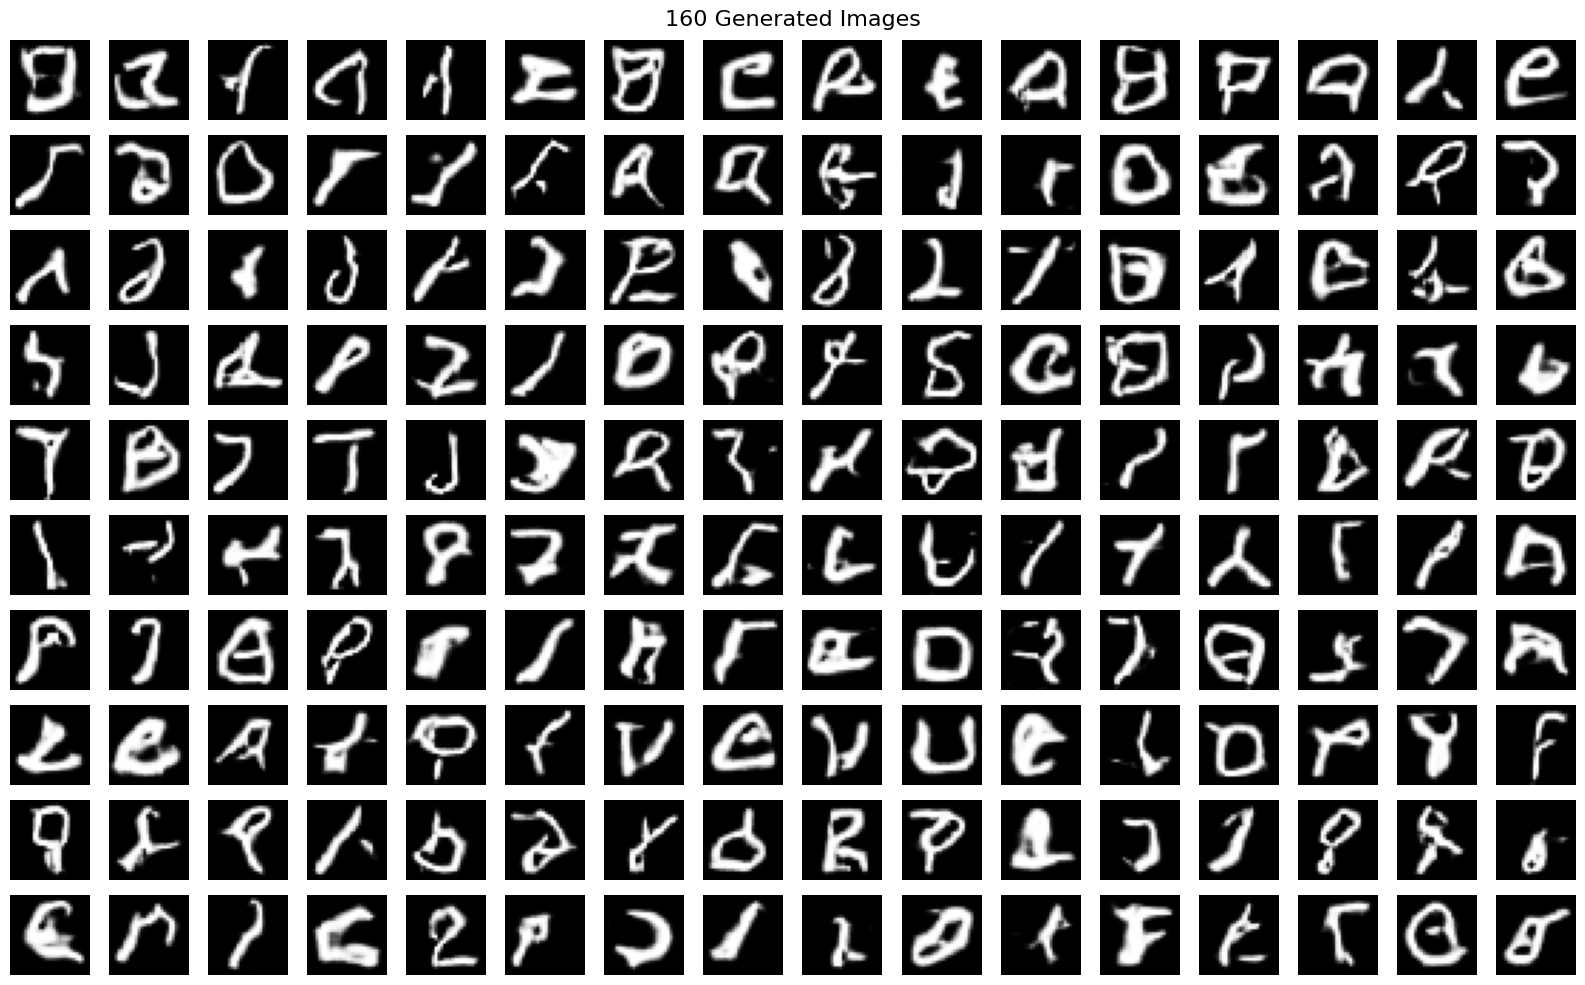


Epoch 11/50
D Loss: 1.3525 | G Loss: 0.8703 | D Acc: 0.5653

Epoch 12/50
D Loss: 1.3495 | G Loss: 0.8715 | D Acc: 0.5683

Epoch 13/50
D Loss: 1.3532 | G Loss: 0.8676 | D Acc: 0.5650

Epoch 14/50
D Loss: 1.3536 | G Loss: 0.8661 | D Acc: 0.5649

Epoch 15/50
D Loss: 1.3540 | G Loss: 0.8631 | D Acc: 0.5627

Epoch 16/50
D Loss: 1.3530 | G Loss: 0.8631 | D Acc: 0.5641

Epoch 17/50
D Loss: 1.3549 | G Loss: 0.8611 | D Acc: 0.5610

Epoch 18/50
D Loss: 1.3535 | G Loss: 0.8609 | D Acc: 0.5619

Epoch 19/50
D Loss: 1.3523 | G Loss: 0.8617 | D Acc: 0.5637

Epoch 20/50
D Loss: 1.3528 | G Loss: 0.8627 | D Acc: 0.5628


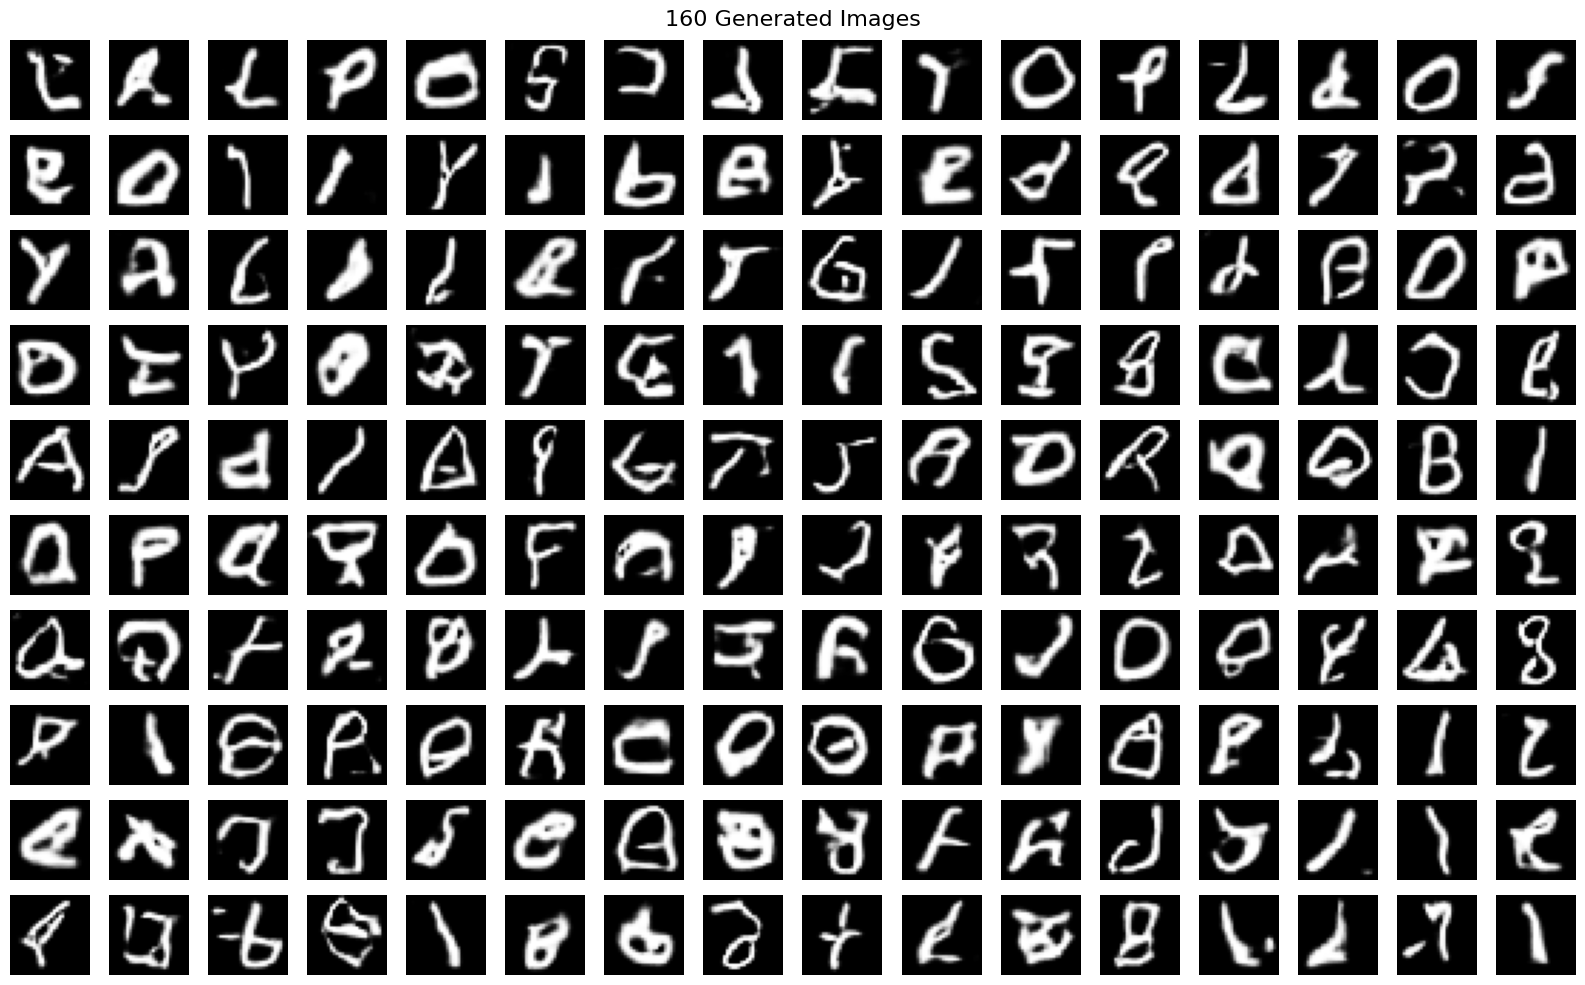


Epoch 21/50
D Loss: 1.3508 | G Loss: 0.8632 | D Acc: 0.5650

Epoch 22/50
D Loss: 1.3519 | G Loss: 0.8626 | D Acc: 0.5649

Epoch 23/50
D Loss: 1.3529 | G Loss: 0.8611 | D Acc: 0.5640

Epoch 24/50
D Loss: 1.3533 | G Loss: 0.8602 | D Acc: 0.5609

Epoch 25/50
D Loss: 1.3520 | G Loss: 0.8618 | D Acc: 0.5650

Epoch 26/50
D Loss: 1.3513 | G Loss: 0.8610 | D Acc: 0.5648

Epoch 27/50
D Loss: 1.3505 | G Loss: 0.8616 | D Acc: 0.5642

Epoch 28/50
D Loss: 1.3513 | G Loss: 0.8617 | D Acc: 0.5657

Epoch 29/50
D Loss: 1.3503 | G Loss: 0.8629 | D Acc: 0.5672

Epoch 30/50
D Loss: 1.3510 | G Loss: 0.8630 | D Acc: 0.5644


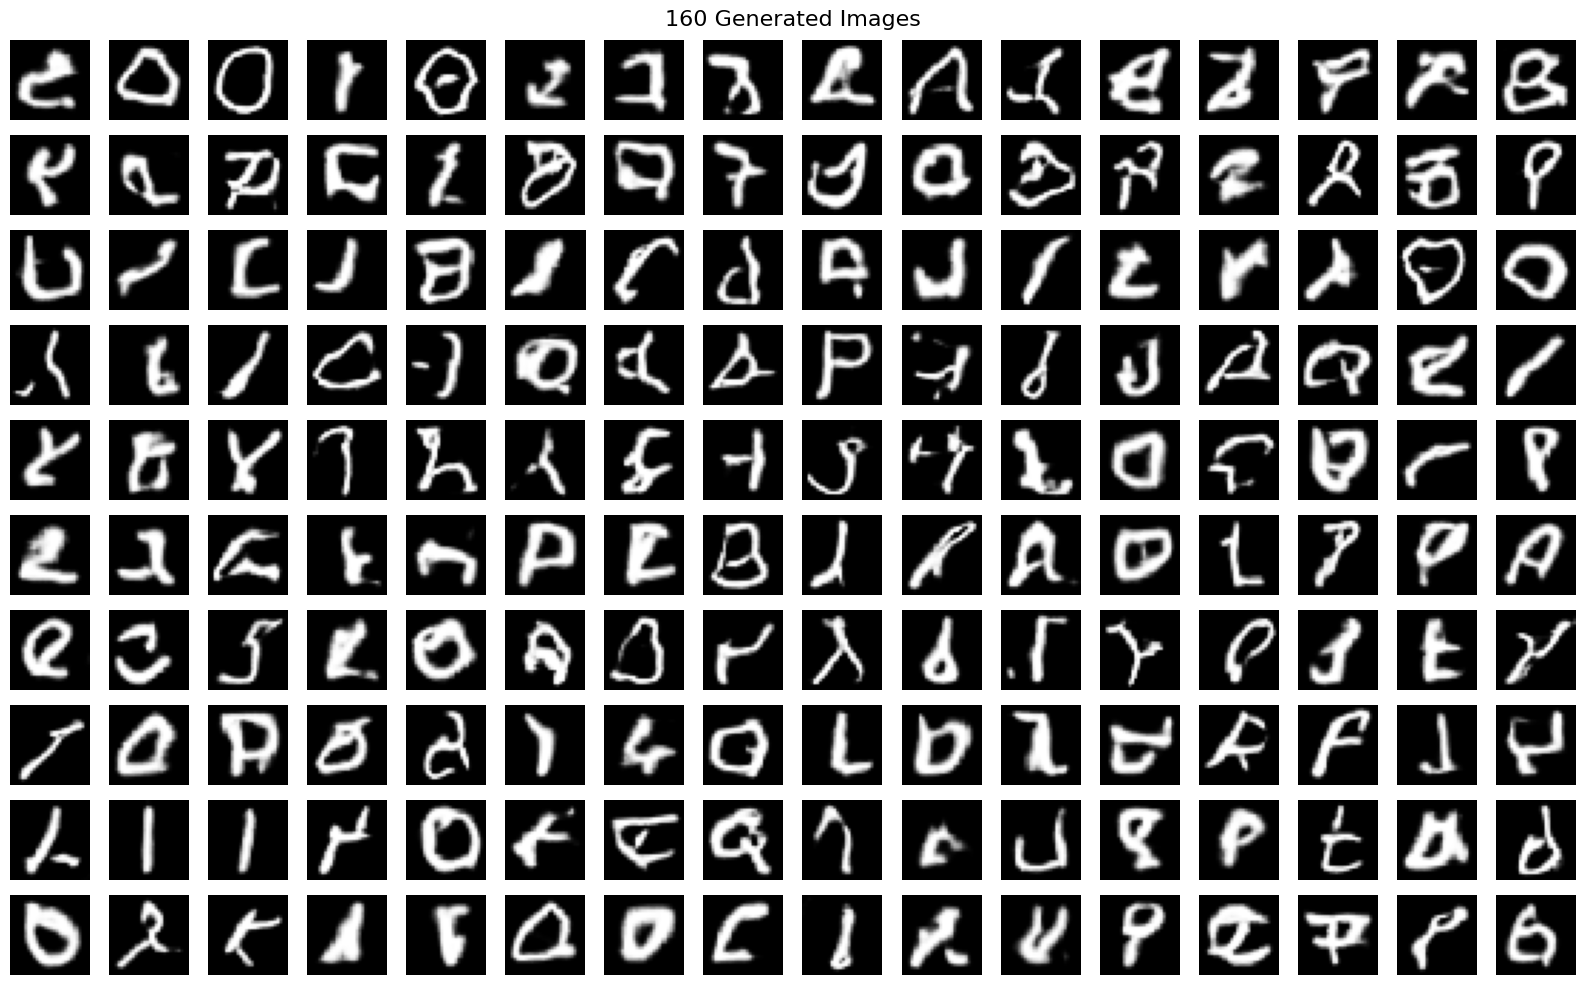


Epoch 31/50
D Loss: 1.3507 | G Loss: 0.8630 | D Acc: 0.5638

Epoch 32/50
D Loss: 1.3506 | G Loss: 0.8622 | D Acc: 0.5631

Epoch 33/50
D Loss: 1.3487 | G Loss: 0.8636 | D Acc: 0.5678

Epoch 34/50
D Loss: 1.3493 | G Loss: 0.8635 | D Acc: 0.5635

Epoch 35/50
D Loss: 1.3480 | G Loss: 0.8644 | D Acc: 0.5677

Epoch 36/50
D Loss: 1.3485 | G Loss: 0.8648 | D Acc: 0.5670

Epoch 37/50
D Loss: 1.3490 | G Loss: 0.8638 | D Acc: 0.5673

Epoch 38/50
D Loss: 1.3480 | G Loss: 0.8656 | D Acc: 0.5682

Epoch 39/50
D Loss: 1.3484 | G Loss: 0.8646 | D Acc: 0.5661

Epoch 40/50
D Loss: 1.3489 | G Loss: 0.8655 | D Acc: 0.5682


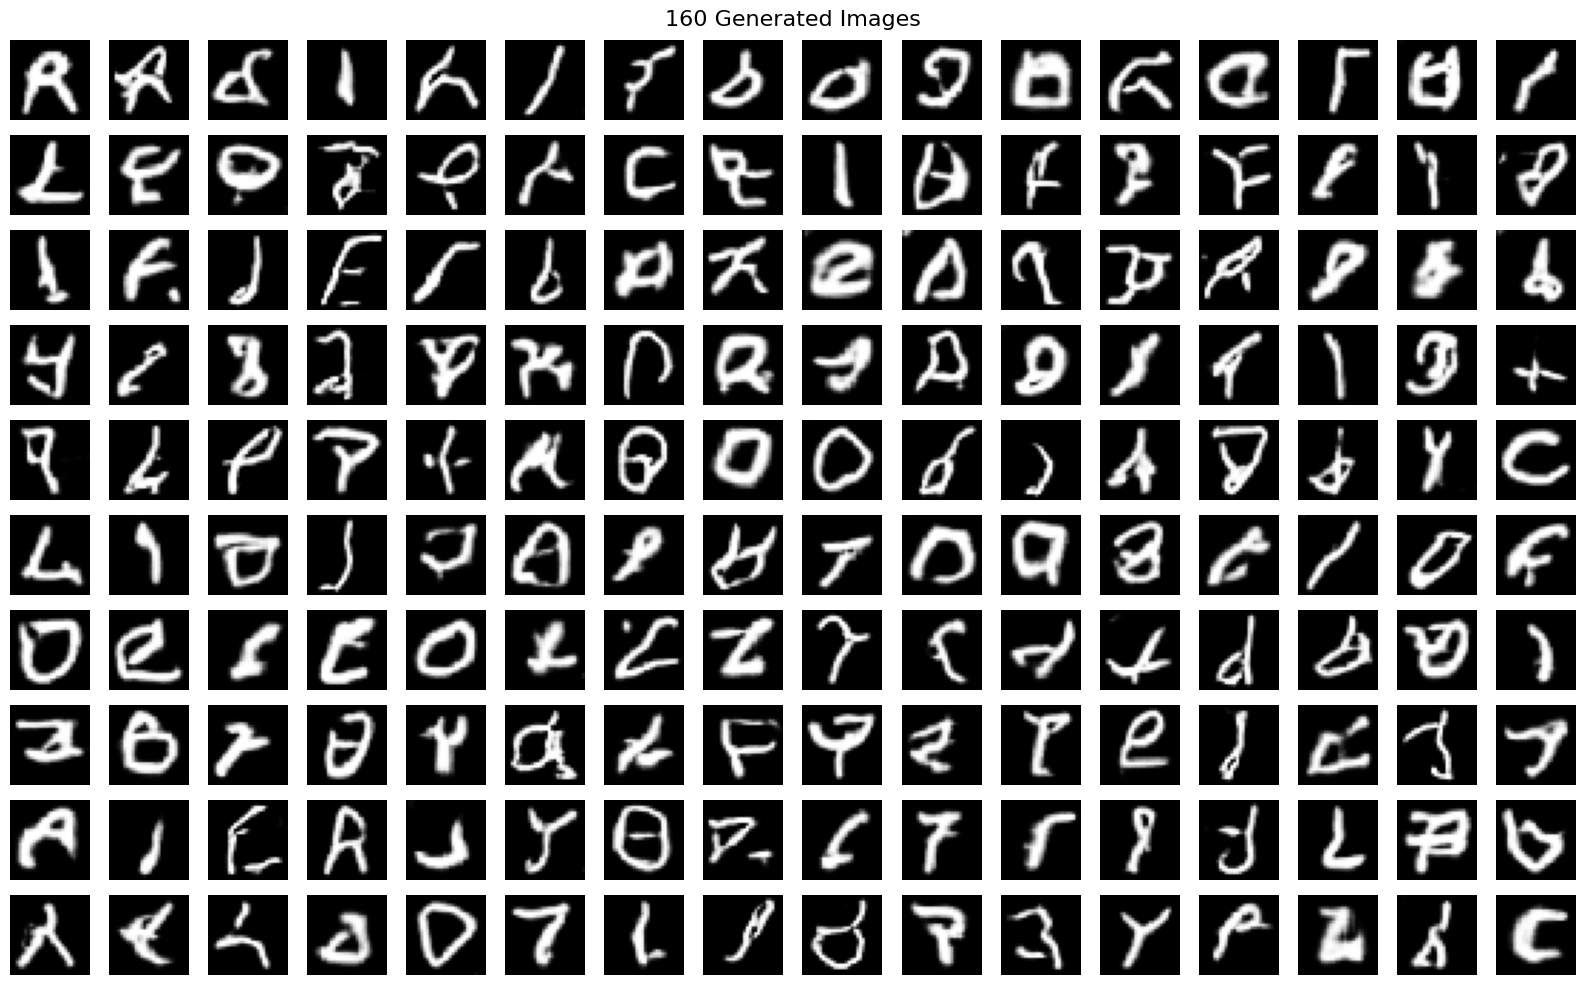


Epoch 41/50
D Loss: 1.3466 | G Loss: 0.8666 | D Acc: 0.5693

Epoch 42/50
D Loss: 1.3468 | G Loss: 0.8682 | D Acc: 0.5711

Epoch 43/50
D Loss: 1.3469 | G Loss: 0.8669 | D Acc: 0.5663

Epoch 44/50
D Loss: 1.3481 | G Loss: 0.8663 | D Acc: 0.5680

Epoch 45/50
D Loss: 1.3451 | G Loss: 0.8688 | D Acc: 0.5714

Epoch 46/50
D Loss: 1.3456 | G Loss: 0.8687 | D Acc: 0.5693

Epoch 47/50
D Loss: 1.3460 | G Loss: 0.8689 | D Acc: 0.5697

Epoch 48/50
D Loss: 1.3462 | G Loss: 0.8688 | D Acc: 0.5719

Epoch 49/50
D Loss: 1.3466 | G Loss: 0.8680 | D Acc: 0.5691

Epoch 50/50
D Loss: 1.3467 | G Loss: 0.8689 | D Acc: 0.5693


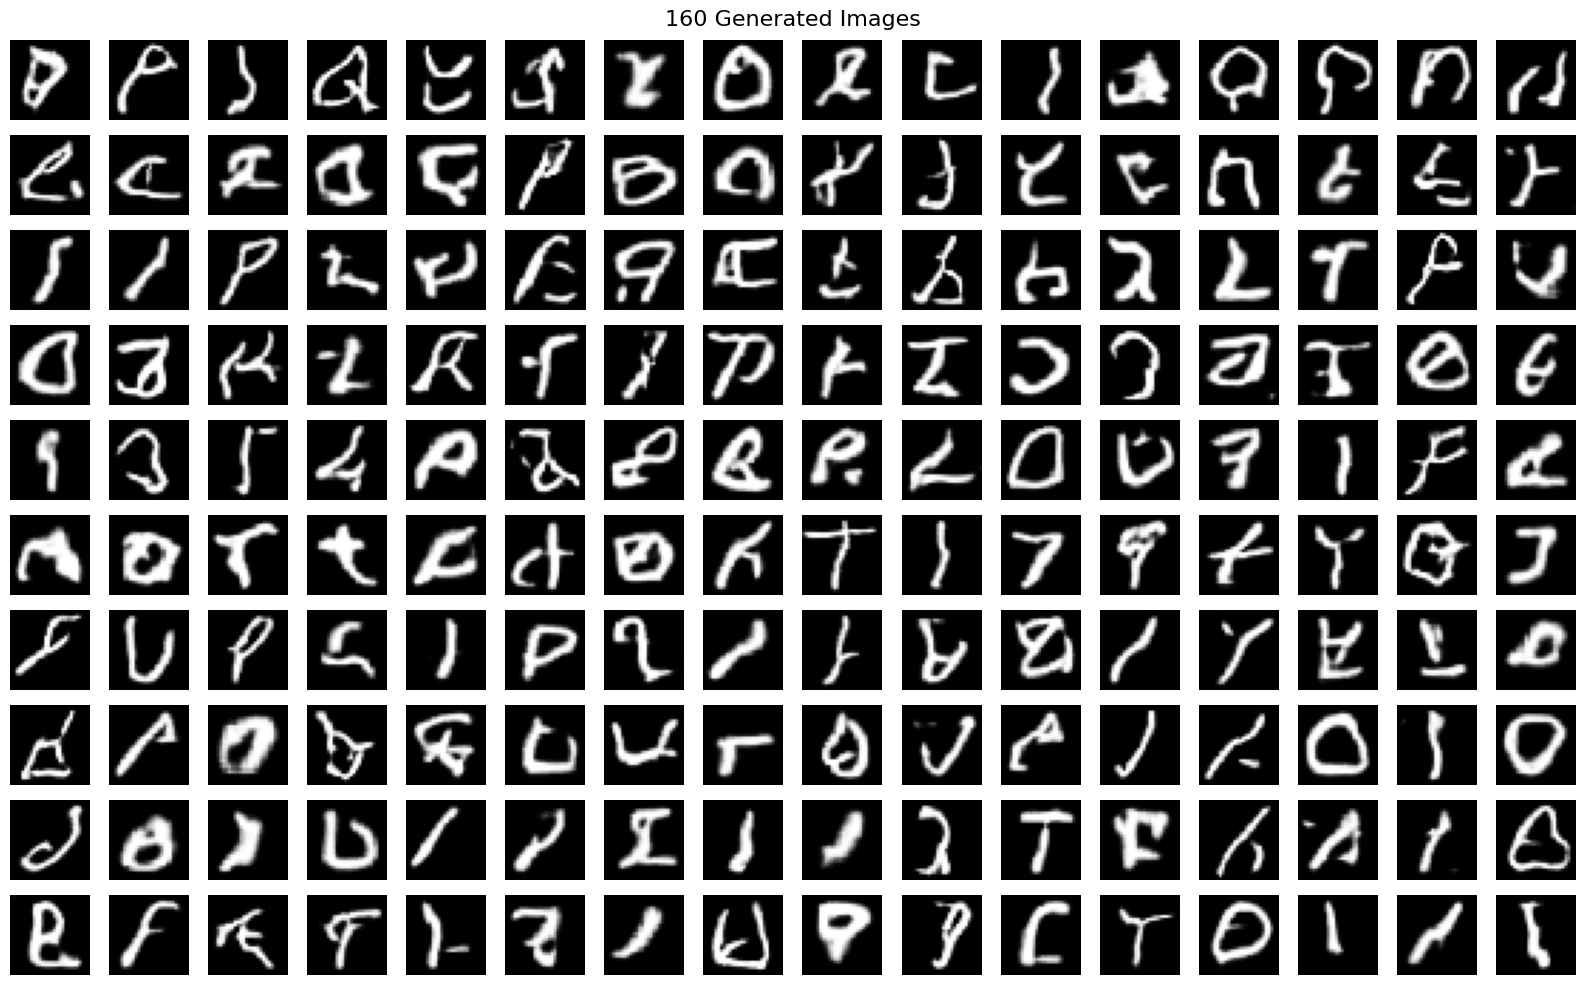

In [33]:
EPOCHS = 50  # Total number of training epochs

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Lists to store metrics for each batch in this epoch
    d_losses, g_losses, d_accuracies = [], [], []

    # === Iterate over all batches in the dataset ===
    for batch in dataset:
        # Train once on the current batch
        metrics = dcgan.train_step(batch)

        # Store batch metrics (convert from tensors to NumPy values)
        d_losses.append(metrics["d_loss"].numpy())       # Discriminator loss
        g_losses.append(metrics["g_loss"].numpy())       # Generator loss
        d_accuracies.append(metrics["d_accuracy"].numpy())  # Discriminator accuracy

    # === Compute average metrics for the whole epoch ===
    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)
    avg_d_accuracy = np.mean(d_accuracies)

    # Store averages in the training history dictionary
    history["d_loss"].append(avg_d_loss)
    history["g_loss"].append(avg_g_loss)
    history["d_accuracy"].append(avg_d_accuracy)

    # Print the epoch’s average metrics
    print(f"D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f} | D Acc: {avg_d_accuracy:.4f}")

    # === Show generated samples every 10 epochs ===
    if (epoch + 1) % 10 == 0:
        show_160_images(dcgan.generator, latent_dim=latent_dim)


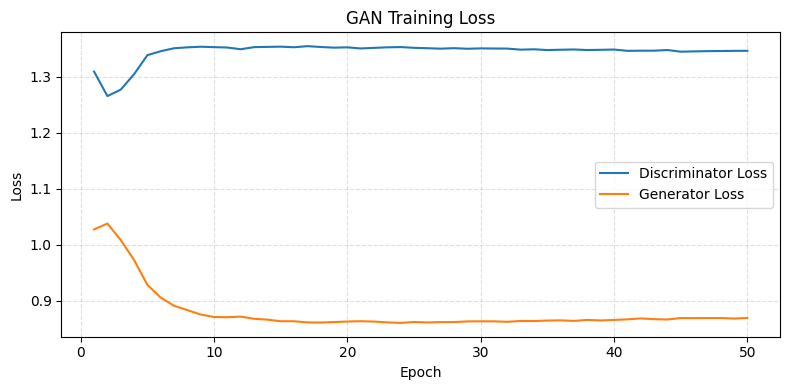

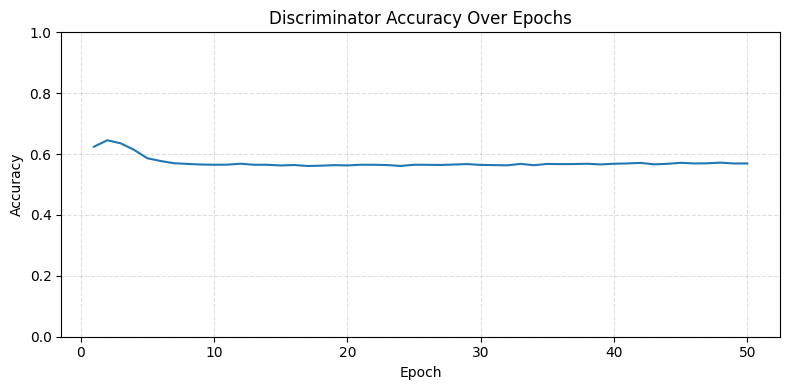

In [40]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(1, len(history["d_loss"])+1)

# --- Loss curves ---
plt.figure(figsize=(8,4))
plt.plot(epochs_range, history["d_loss"], label="Discriminator Loss")
plt.plot(epochs_range, history["g_loss"], label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Discriminator accuracy ---
plt.figure(figsize=(8,4))
plt.plot(epochs_range, history["d_accuracy"], label="Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.ylim(0, 1)  # since it's an accuracy
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [36]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

def show_160_images(generator, latent_dim=128, save_path="DCGAN(1)generated_images/generated_160_grid.png"):
    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Generate 160 noise vectors
    noise = tf.random.normal([160, latent_dim])  # Noise = diversity

    # Generate fake images from noise
    generated_images = generator(noise, training=False)

    # Normalize generated images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1.0) / 2.0

    # Create a 16x10 grid of images
    fig = plt.figure(figsize=(16, 10))
    for i in range(160):
        plt.subplot(10, 16, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle("Generated 160 Images", fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)


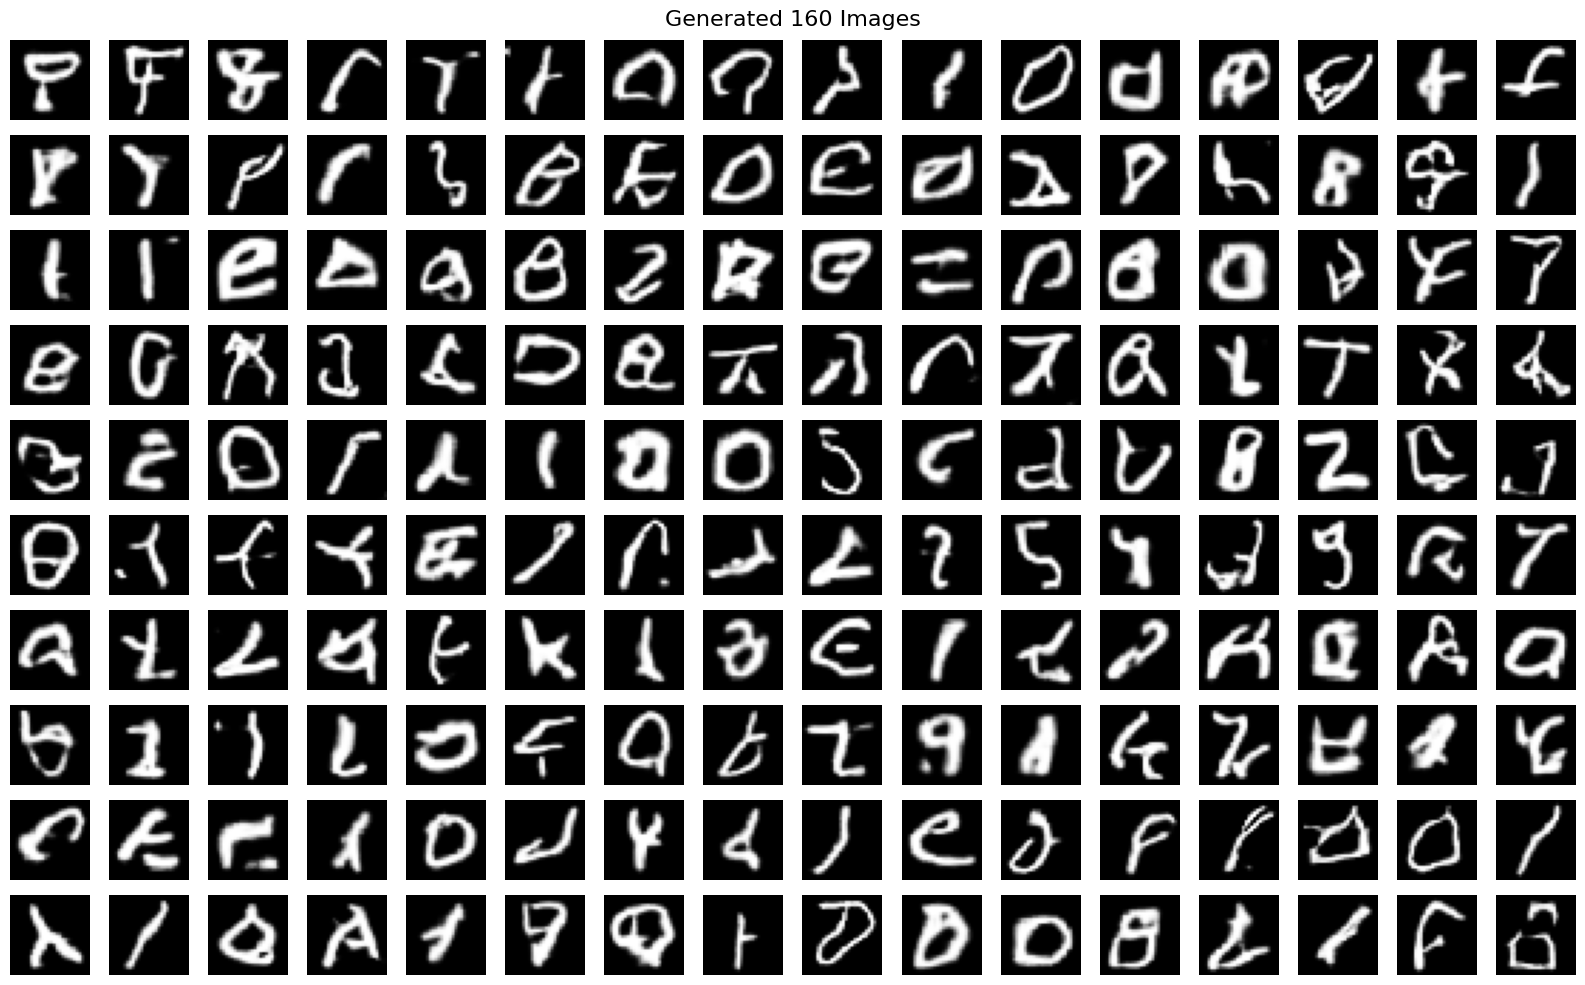

In [37]:
show_160_images(generator, latent_dim=150)


s

<a id="dcgan-model-improvement-4-500-epochs"></a>
# DCGAN Model Improvement  - 500 epochs

## Model Improvement: From Baseline DCGAN to Enhanced DCGAN

We upgraded both the **Generator** and **Discriminator** to improve sample quality and training stability.

### What Changed in the **Generator**
**Before (baseline):**
- Dense → reshape to **7×7×128**
- 2× `UpSampling2D + Conv2D` stacks (128 → 64)
- Output: `Conv2D(..., activation='tanh')`

**Now (improved):**
- Dense → reshape to **7×7×256**  ⟶ **more capacity**
- Two **Conv2DTranspose** (stride=2) upsampling blocks:
  - `256 → 128 → 28×28`
- **Extra refinement block** (no upsampling):
  - `Conv2DTranspose(64, stride=1)` to add detail at full resolution
- **BatchNorm(momentum=0.8)** after each upsampling
- Output: `Conv2D(...); tanh`

**Why this helps**
- **Transposed conv** replaces `UpSampling2D+Conv2D`: learns the upsampling kernel → better textures and fewer checkerboard artifacts when kernels/strides are set consistently.
- **Higher channel width (256)** at low resolution gives the model more representational power.
- **Refinement at 28×28** lets the network sharpen edges and fill fine details after reaching the target size.
- **BatchNorm(momentum=0.8)** stabilizes training and speeds convergence in GANs.

---

### What Changed in the **Discriminator**
**Before (baseline):**
- Two downsampling blocks: `Conv2D(64, s=2)` → `Conv2D(128, s=2)`
- BatchNorm only in the second block
- Dropout(0.3)
- Flatten → Dense(1, sigmoid)

**Now (improved):**
- Same first two blocks, but:
  - **BatchNorm** added consistently
  - **Dropout increased to 0.4** for stronger regularization
- **Added third conv block** at full resolution:
  - `Conv2D(256, stride=1)` + BatchNorm + LeakyReLU + Dropout
- Flatten → Dense(1, sigmoid)

**Why this helps**
- **Extra conv block (stride=1)** increases capacity to inspect local details at the native resolution, making the discriminator more discerning without overly reducing spatial size.
- **Stronger dropout** reduces overfitting and prevents the discriminator from overpowering the generator early.
- **Consistent BatchNorm** improves gradient flow and stability.




In [40]:
def build_generator(latent_dim, channels=1):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)


In [41]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)


In [42]:
# ==== Data Preparation ====

import tensorflow as tf

batch_size = 64
buffer_size = 10000 

# DCGAN Dataset (images only)
dcgan_dataset = (tf.data.Dataset.from_tensor_slices(images)
                .shuffle(buffer_size, reshuffle_each_iteration=True)
                .batch(batch_size, drop_remainder=True)
                .prefetch(tf.data.AUTOTUNE))

In [43]:
class DCGANModel(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def compile(self, g_optimizer, d_optimizer):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer

    def generator_loss(self, fake_output):
        return self.loss_fn(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss_fn(tf.ones_like(real_output) * 0.9, real_output)  # label smoothing
        fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            d_loss = self.discriminator_loss(real_output, fake_output)
            g_loss = self.generator_loss(fake_output)

        grads_d = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        grads_g = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables))

        # === Discriminator Accuracy ===
        real_accuracy = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
        fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
        d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

        return {"d_loss": d_loss, "g_loss": g_loss, "d_accuracy": d_accuracy}

    def save_all_weights(self, prefix="dcgan"):
        self.generator.save_weights(f"{prefix}_generator_500.h5")
        self.discriminator.save_weights(f"{prefix}_discriminator.h5")
        self.save_weights(f"{prefix}_combined.h5")
        print("All weights saved.")

    def load_all_weights(self, prefix="dcgan"):
        self.generator.load_weights(f"{prefix}_generator_500.h5")
        self.discriminator.load_weights(f"{prefix}_discriminator.h5")
        self.load_weights(f"{prefix}_combined.h5")
        print("All weights loaded.")


In [46]:
# ==== Instantiate Models ====
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization,
    Reshape, Conv2DTranspose, Input, Activation
)


latent_dim = 128 

generator = build_generator(latent_dim, channels=1)
discriminator = build_discriminator(img_shape=(28, 28, 1))

# Confirm model architecture
generator.summary()
discriminator.summary()

dcgan = DCGANModel(generator, discriminator, latent_dim)

dcgan.compile(
    g_optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         2579457   
                                                                 
Total params: 2,579,457
Trainable params: 2,578,561
Non-trainable params: 896
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_5 (Sequential)   (None, 1)                 383745    
                                                                 
Total params: 383,745
Trainabl

In [47]:
# ==== Callback for Monitoring ====

import os
import matplotlib.pyplot as plt
import tensorflow as tf

class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_images=25, latent_dim=128, save_dir="DCGAN_500_epochs_generated_images", save_interval=50):
        super().__init__()
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        self.save_interval = save_interval
        self.seed = tf.random.normal([num_images, latent_dim])
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # Save images only every `save_interval` epochs
        if (epoch + 1) % self.save_interval == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = (generated_images + 1) / 2.0  # Rescale to [0,1]

            fig = plt.figure(figsize=(5, 5))
            for i in range(self.num_images):
                plt.subplot(5, 5, i + 1)
                plt.imshow(generated_images[i, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.suptitle(f"Epoch {epoch + 1}")

            save_path = os.path.join(self.save_dir, f"generated_epoch_{epoch + 1}.png")
            plt.savefig(save_path)
            plt.close(fig)


In [48]:
def generate_and_save_all(generator, latent_dim=128, num_classes=16, images_per_class=10, 
                          save_dir="DCGAN(1)_generated_images", grid_path="DCGAN(4)generated_160_grid.png"):
    os.makedirs(save_dir, exist_ok=True)
    all_images = []

    for i in range(num_classes):
        noise = np.random.normal(0, 1, (images_per_class, latent_dim))
        generated_images = generator(noise, training=False)
        generated_images = 0.5 * generated_images + 0.5  # Rescale to [0,1]

        # Optional: Save individual images
        class_dir = os.path.join(save_dir, f"group_{i}")
        os.makedirs(class_dir, exist_ok=True)
        for j in range(images_per_class):
            img = generated_images[j, :, :, 0]
            plt.imsave(os.path.join(class_dir, f"img_{j+1}.png"), img, cmap='gray')

        all_images.extend(generated_images[:, :, :, 0])

    # Save 160-image grid
    plt.figure(figsize=(20, 32))
    for i, img in enumerate(all_images):
        plt.subplot(num_classes, images_per_class, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(grid_path)
    plt.show()


In [49]:
import tensorflow as tf

epochs = 500
g_losses = []
d_losses = []
d_accuracies = []

monitor = GANMonitor(num_images=25, latent_dim=latent_dim, save_dir="DCGAN_500_epochs_generated_images", save_interval=50)
monitor.model = dcgan

# ========== Training Loop ==========
for epoch in range(epochs):
    for real_images in dataset:
        logs = dcgan.train_step(real_images)

    g_losses.append(logs["g_loss"].numpy())
    d_losses.append(logs["d_loss"].numpy())
    d_accuracies.append(logs["d_accuracy"].numpy())

    monitor.on_epoch_end(epoch)

    print(f"Epoch {epoch + 1}/{epochs} - G Loss: {g_losses[-1]:.4f}, D Loss: {d_losses[-1]:.4f}, D Accuracy: {d_accuracies[-1]:.4f}")


# Save final generator weights
generator.save_weights("dcgan_generator_500_weights.h5")

Epoch 1/500 - G Loss: 1.0601, D Loss: 1.2520, D Accuracy: 0.6724
Epoch 2/500 - G Loss: 1.1210, D Loss: 1.2584, D Accuracy: 0.6552
Epoch 3/500 - G Loss: 1.0861, D Loss: 1.2190, D Accuracy: 0.6724
Epoch 4/500 - G Loss: 0.8848, D Loss: 1.3609, D Accuracy: 0.5690
Epoch 5/500 - G Loss: 0.9465, D Loss: 1.3604, D Accuracy: 0.5776
Epoch 6/500 - G Loss: 1.0735, D Loss: 1.3156, D Accuracy: 0.5776
Epoch 7/500 - G Loss: 0.8847, D Loss: 1.3142, D Accuracy: 0.6207
Epoch 8/500 - G Loss: 0.9727, D Loss: 1.3750, D Accuracy: 0.5517
Epoch 9/500 - G Loss: 1.0522, D Loss: 1.2275, D Accuracy: 0.6810
Epoch 10/500 - G Loss: 0.8431, D Loss: 1.3326, D Accuracy: 0.5948
Epoch 11/500 - G Loss: 0.8105, D Loss: 1.2947, D Accuracy: 0.6121
Epoch 12/500 - G Loss: 0.8286, D Loss: 1.4070, D Accuracy: 0.4914
Epoch 13/500 - G Loss: 0.9532, D Loss: 1.3493, D Accuracy: 0.5776
Epoch 14/500 - G Loss: 1.0426, D Loss: 1.2306, D Accuracy: 0.6466
Epoch 15/500 - G Loss: 1.0106, D Loss: 1.2499, D Accuracy: 0.6638
Epoch 16/500 - G Lo

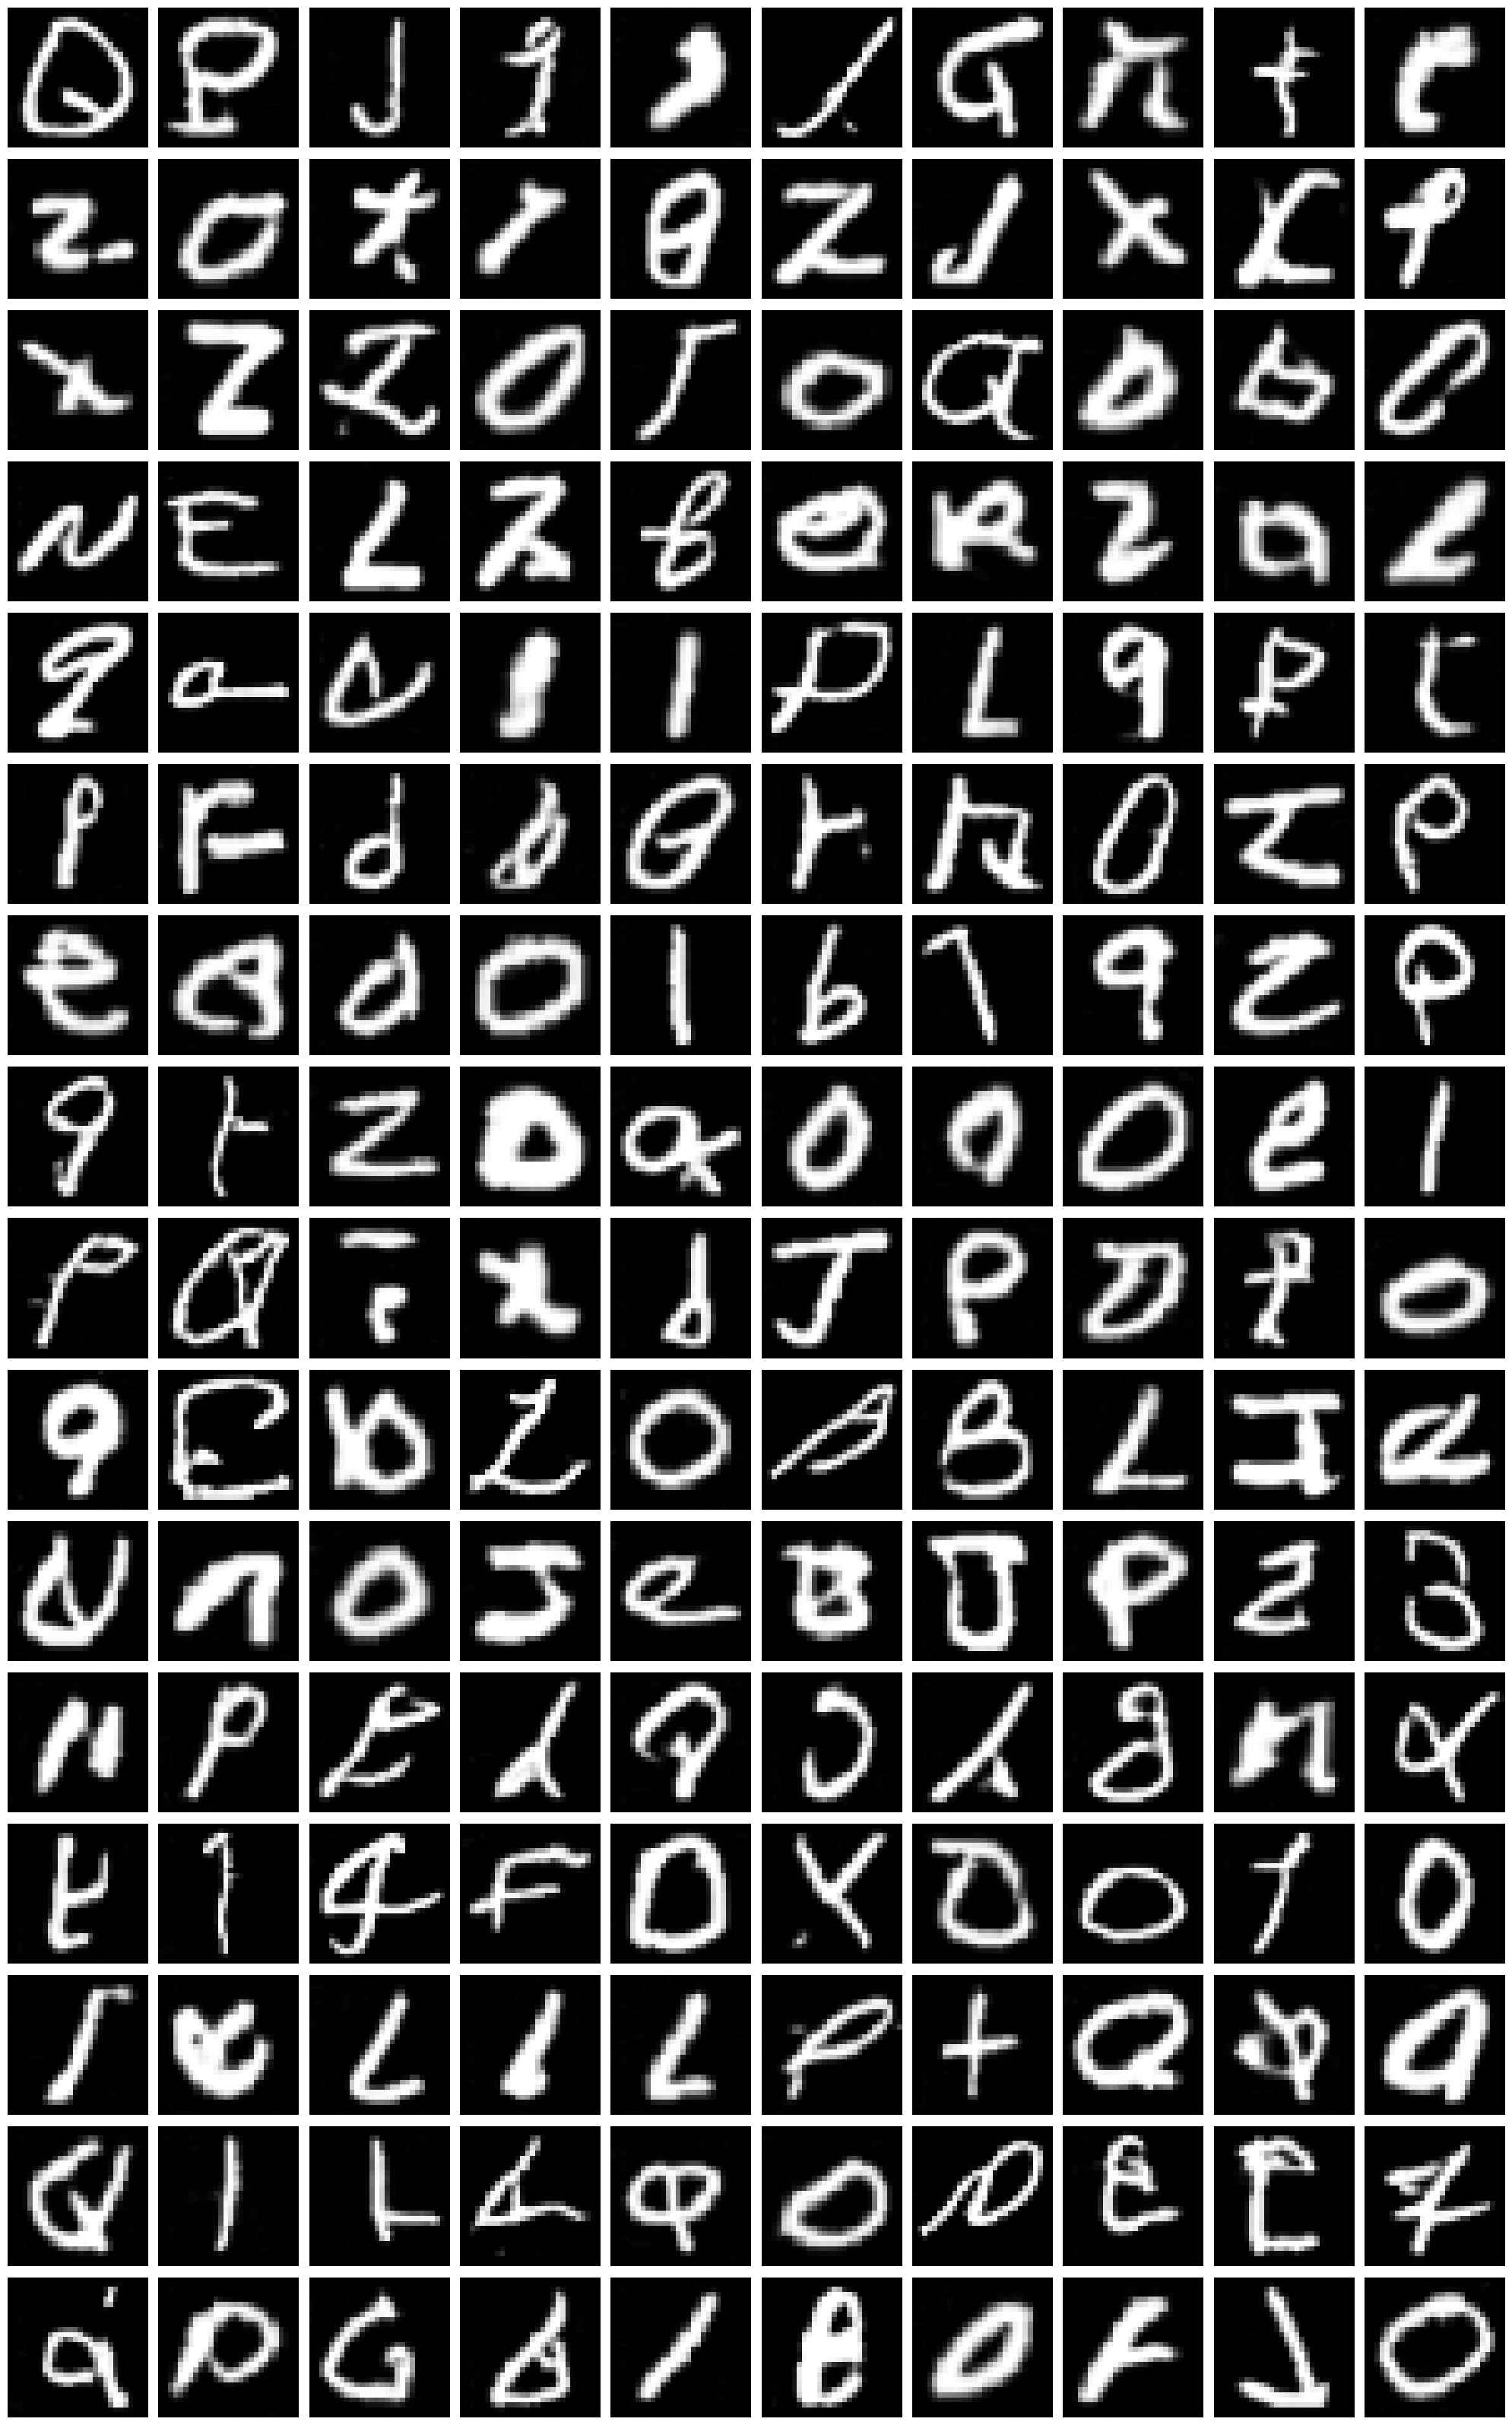

In [57]:


# ========== Final 160-Image Grid ==========
generate_and_save_all(generator, latent_dim=latent_dim, num_classes=16, images_per_class=10,
                      save_dir="NEW_DCGAN_generated_images", 
                      grid_path="DCGAN(1)generated_160_grid.png")

generator.save_weights("dcgan_generator_500_weights.h5")


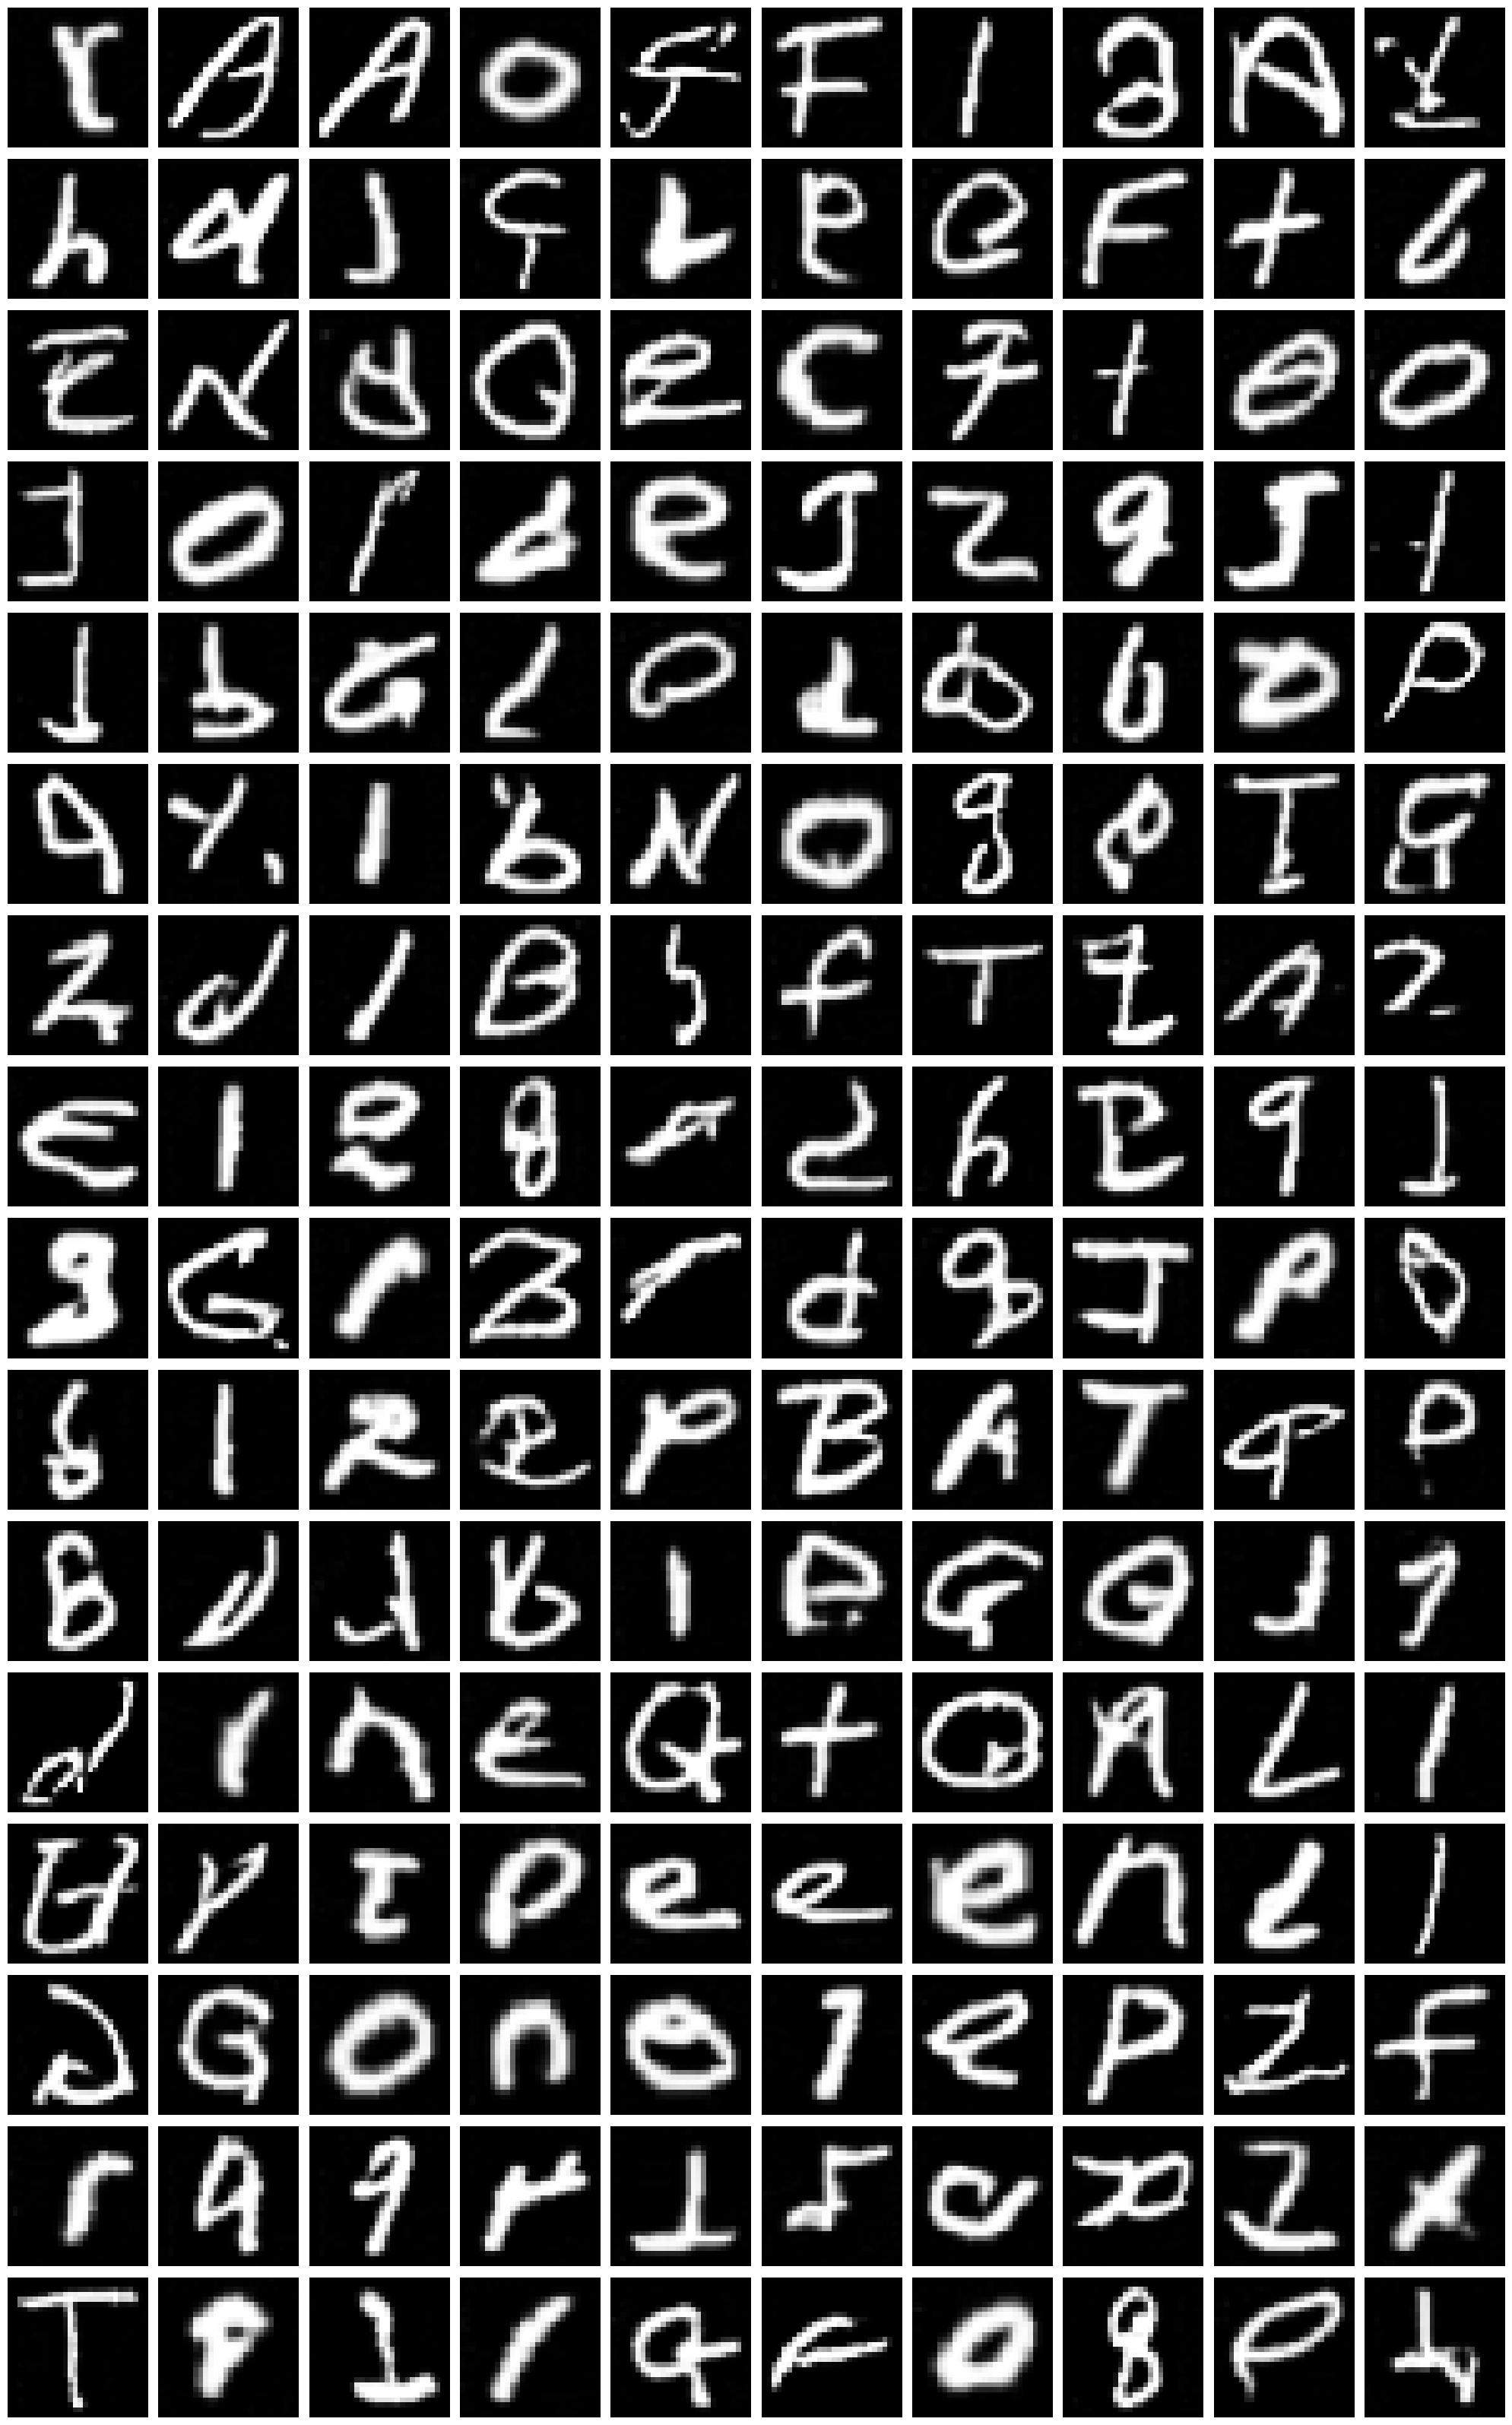

In [58]:


# ========== Final 160-Image Grid ==========
generate_and_save_all(generator, latent_dim=latent_dim, num_classes=16, images_per_class=10,
                      save_dir="NEW_DCGAN_generated_images", 
                      grid_path="DCGAN(2)generated_160_grid.png")

generator.save_weights("dcgan_generator_500_weights.h5")


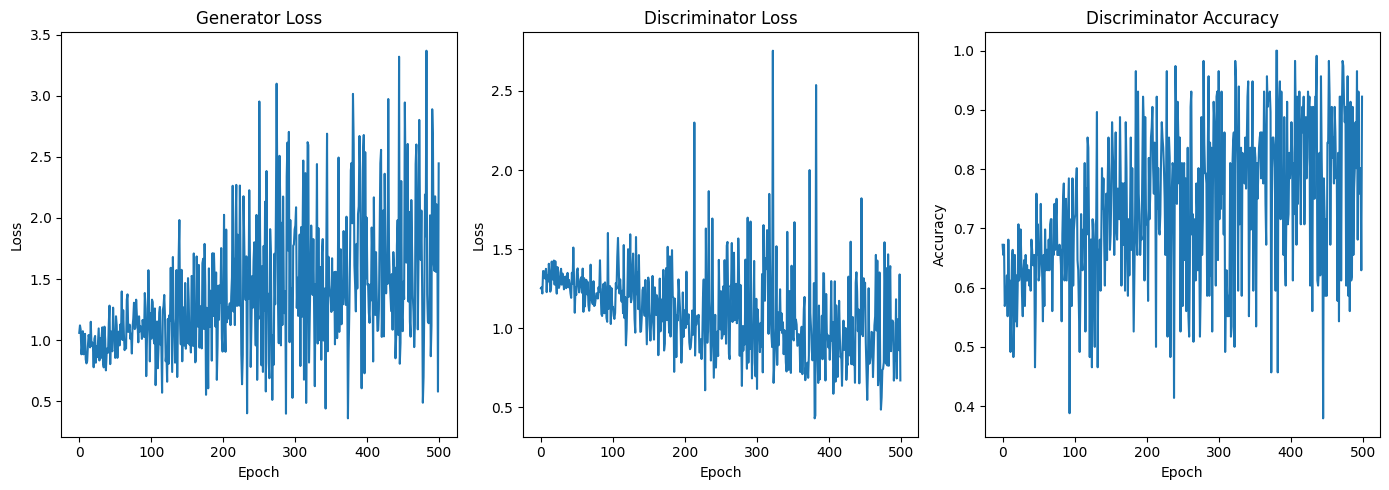

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(g_losses, label="Generator Loss")
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


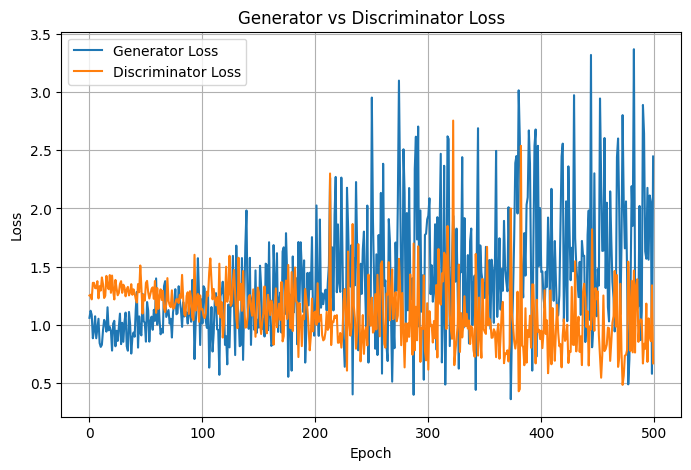

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Generator vs Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Final DCGAN Model Results 

### Loss and Accuracy Trends
Below are the training curves for the final DCGAN model after 500 epochs:

1. **Generator Loss** – Shows how well the generator is learning to produce realistic images.  
2. **Discriminator Loss** – Measures the discriminator’s ability to distinguish between real and fake images.  
3. **Discriminator Accuracy** – Tracks the percentage of correct predictions made by the discriminator.


### Combined Loss Comparison
This plot directly compares **Generator Loss** and **Discriminator Loss** over time, allowing us to observe the adversarial training balance.


### Observations
- The **discriminator accuracy** stabilizes around 80–90%, indicating a healthy adversarial balance.
- **Generator loss** fluctuates more widely than discriminator loss, which is expected due to adversarial dynamics.
- The **loss gap** between generator and discriminator remains moderate, suggesting neither model is overpowering the other.
- Despite noise in the curves, overall training shows both networks actively learning throughout the epochs.
